# Import

In [1]:
import math
import os, sys
from icecream import ic
from typing import Iterable
from IPython.display import  Markdown, display

##os.getcwd()
if "../scripts/" not in sys.path:  # to prevent multi adding  
    sys.path.append("../scripts/")
     
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from helpers import flatten_list_of_dicts
from input_output_plot.printing import output_formatting as paint
from input_output_plot.printing import display_df_side_by_side
from consts import format, color, del_format, results_dir, pkl_dir

# Load data sets

In [2]:
#X_train_file_small = os.path.join(pkl_dir, 'x_train_features_small.pkl')
X_train_file = os.path.join(pkl_dir, 'x_train_features.pkl')
X_train_addition_file = os.path.join(pkl_dir, 'x_train_addition_features.pkl')
y_train_file = os.path.join(pkl_dir, 'y_train_features.pkl')
X_train_return_file = os.path.join(pkl_dir, 'x_train_return_features.pkl')
x_train_capped_features_file = os.path.join(pkl_dir, 'x_train_capped_features.pkl')
X_test_file = os.path.join(pkl_dir, 'x_test_features.pkl')
X_test_addition_file = os.path.join(pkl_dir, 'x_test_addition_features.pkl')
y_test_file = os.path.join(pkl_dir, 'y_test_features.pkl')
X_test_return_file = os.path.join(pkl_dir, 'x_test_return_features.pkl')

sp500_history_file = os.path.join(pkl_dir, 'sp500_history.pkl')

In [3]:
print(f'Load previously saved data from {pkl_dir}')
with open(X_train_file, 'rb') as fx, open(X_train_addition_file, 'rb') as fxa, open(y_train_file, 'rb') as fy, open(X_train_return_file, 'rb') as fxt, open(x_train_capped_features_file, 'rb') as fxc:
    X_train = pickle.load(fx)
    X_train_addition = pickle.load(fxa)
    y_train = pickle.load(fy)
    X_train_return = pickle.load(fxt)
    X_train_capped = pickle.load(fxc)

with open(X_test_file, 'rb') as fx, open(X_test_addition_file, 'rb') as fxa, open(y_test_file, 'rb') as fy, open(X_test_return_file, 'rb') as fxt:
    X_test = pickle.load(fx)
    X_test_addition = pickle.load(fxa)
    y_test = pickle.load(fy)
    X_test_return = pickle.load(fxt)

with open(sp500_history_file, 'rb') as f:
    sp500_history = pickle.load(f)

Load previously saved data from ../results/pickled


# Cross validation

In [4]:
from input_output_plot.plotting import plot_cv
from model.model_selection import MultiTimeSeriesSplit

## Determine folds sizes

The task's requirement for cross-validation is "the train set has to be bigger than 2 years history". Let determine the number of days in the first 2 years of the train set.

In [5]:
statistic = {}
statistic['n_companies_train'] = len(X_train['Name'].unique())
statistic['n_companies_test'] = len(X_test['Name'].unique())
print(f'Number of companies in the train set: {paint(statistic['n_companies_train'], format)}')
print(f'Number of companies in the test set: {paint(statistic['n_companies_test'], format)}')

Number of companies in the train set: 498
Number of companies in the test set: 505


In [6]:
X_train_dates= X_train.index.unique()
statistic['X_train_dates'] = len(X_train_dates)
print(f'Days in the the train set: {paint(statistic['X_train_dates'], format)}')
days_in_2years_history = len(X_train_dates[(X_train_dates>=X_train_dates.min()) & (X_train_dates<X_train_dates.min()+pd.DateOffset(years=2))])
statistic['days_in_2years_history'] = days_in_2years_history
print(f'Days in the first 2 years of the train set: {paint(statistic['days_in_2years_history'] , format)}')
statistic['X_test_dates'] = len(X_test.index.get_level_values('date').unique())
print(f'Days in the test set: {paint(statistic['X_test_dates'], format)}')

Days in the the train set: 955
Days in the first 2 years of the train set: 504
Days in the test set: 275


Let's take `validation_set_size`=25 and `n_splits`=11. It will cover the whole X_test: 11*25=275 

In [7]:
validation_set_size=25
n_splits=11

In [8]:
# determine the maximum length of the train fold in the first split which let validation folds cover the given test set 
max_train_size = statistic['X_train_dates'] - statistic['X_test_dates']
statistic['max_train_size'] = max_train_size
print(f'Maximum size of the train fold in the first split: {paint(max_train_size, format)}')

Maximum size of the train fold in the first split: 680


In [9]:
from sklearn.model_selection import TimeSeriesSplit
def is_train_test_folds_have_common_dates(cv: TimeSeriesSplit, X: pd.DataFrame) -> bool:
    """
    Check if there are any overlapping dates between the train and test folds
    produced by a cross-validation splitter.

    Args:
        cv: Cross-validation splitter object with a split method.
        X: DataFrame with a DatetimeIndex or MultiIndex including dates.

    Returns:
        bool: True if any train and test fold share at least one date, False otherwise.
    """
    for tr, tt in cv.split(X=X):
        tr_dates = X.iloc[tr].index.unique()
        tt_dates = X.iloc[tt].index.unique()
        if tr_dates.intersection(tt_dates).size>0:
            return True
    return False

## TimeSeries Split

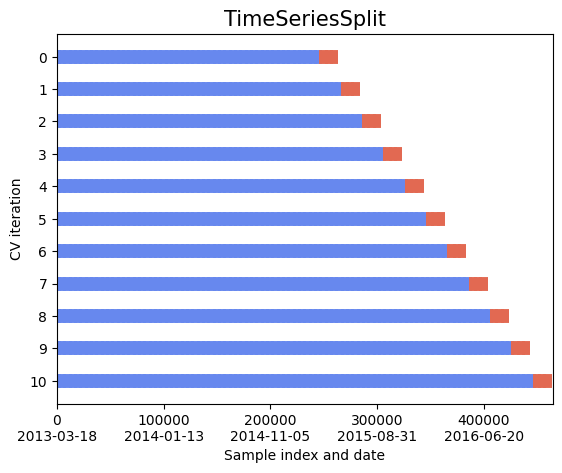

In [10]:
# create a cross-validation object with minimal train set equal 2 years of stock's history + 10 days of stock's history
tscv = MultiTimeSeriesSplit(n_splits=n_splits, 
                            min_train_size=days_in_2years_history+10, 
                            max_train_size=None, 
                            #test_size=validation_set_size, 
                            gap=0)
fig = plot_cv(tscv, 'TimeSeriesSplit', X_train, y_train, scale_x=5000)
display(fig)

This time series split is built with minimum length of train fold according with task requipment (2 years history). Let's get some statistic on it:

In [11]:
statistic['max_days_in_validation_set'] = tscv.get_test_size()
print(f'Length of test (number of days) set in the cross validation showed above: {paint(statistic['max_days_in_validation_set'], format)}')

Length of test (number of days) set in the cross validation showed above: 40


In [12]:
time_series_split_min_train_set = len(X_train)
for train_idxs, _ in tscv.split(X_train):
    time_series_split_min_train_set = min(len(X_train.iloc[train_idxs]), time_series_split_min_train_set)
statistic['samples_in_min_train_set'] = time_series_split_min_train_set
print(f'Length of minimum train fold: {paint(statistic['samples_in_min_train_set'], format)}')

Length of minimum train fold: 248898


Create a cross-validation object with chosen test's length (`25`). Train set is requered to be bigger than `2 years` of stock's history + 10 days of stock's history

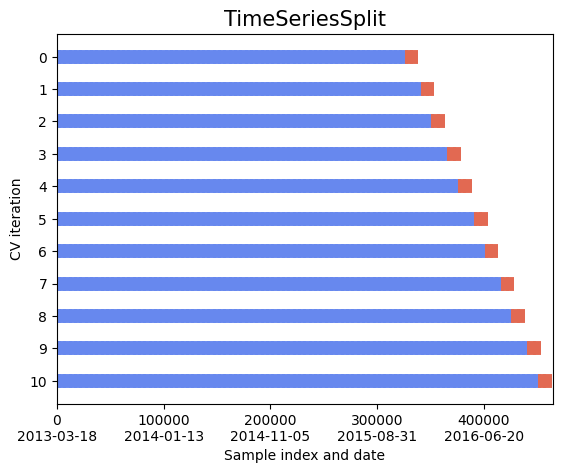

In [13]:
tscv_25 = MultiTimeSeriesSplit(n_splits=n_splits, 
                            min_train_size=days_in_2years_history+10, 
                            max_train_size=None, 
                            test_size=validation_set_size, 
                            gap=0)
fig = plot_cv(tscv_25, 'TimeSeriesSplit', X_train, y_train, scale_x=5000)
display(fig)

In [14]:
print(f'Length of test (number of days) set in the cross validation showed above: {paint(tscv_25.get_test_size(), format)}')
print(f'Minimum length of the train sets (number of days) in the cross-validation above: {paint(tscv_25.get_min_train_size(), format)}')

Length of test (number of days) set in the cross validation showed above: 25
Minimum length of the train sets (number of days) in the cross-validation above: 514


This time the time series split has a train fold with maximum length for the chosen test size.

In [15]:
time_series_split_max_train_set = 0
for train_idxs, _ in tscv_25.split(X_train):
    time_series_split_max_train_set = max(len(X_train.iloc[train_idxs]), time_series_split_max_train_set)
statistic['samples_in_min_train_set'] = time_series_split_max_train_set
print(f'Length of maximum train fold: {paint(statistic['samples_in_min_train_set'], format)}')

Length of maximum train fold: 453962


In [16]:
print(f'Are there data from the same day in the train and test folds : {paint(is_train_test_folds_have_common_dates(tscv, X_train), format)}')

Are there data from the same day in the train and test folds : False


## Blocking TimeSeries Split

In [17]:
tscv_blocking = MultiTimeSeriesSplit(n_splits=n_splits, 
                                     max_train_size=max_train_size, 
                                     min_train_size=days_in_2years_history, 
                                     test_size=validation_set_size, 
                                     gap=0)

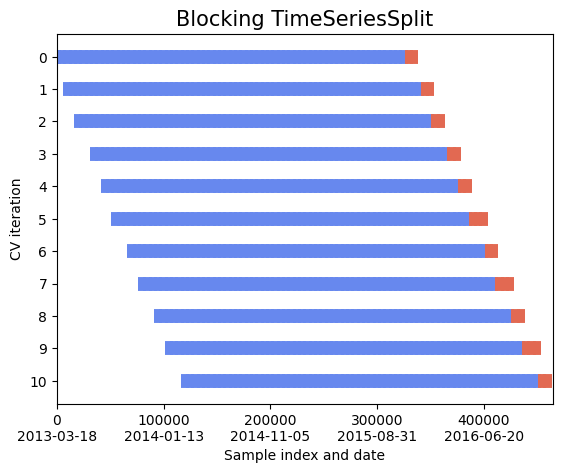

In [18]:
fig = plot_cv(tscv_blocking, 'Blocking TimeSeriesSplit', X_train, y_train, scale_x=5000)
display(fig)

In [19]:
print(f'Minimum length of the train sets {paint('(number of days)',format)} in the cross-validation above: {paint(tscv_blocking.get_min_train_size(), format)}')
print(f'Length of train folds:')
i = 0
end=' -> '
for train_idxs, _ in tscv_blocking.split(X_train):
    if i == n_splits-1:
        end = '\n'
    print(f'{i}: {len(X_train.iloc[train_idxs])}, {len(X_train.iloc[train_idxs]['Name'].unique())}', end=end)
    i += 1

Minimum length of the train sets (number of days) in the cross-validation above: 504
Length of train folds:
0: 329822, 494 -> 1: 330279, 495 -> 2: 330758, 495 -> 3: 331245, 496 -> 4: 331667, 496 -> 5: 332036, 497 -> 6: 332411, 497 -> 7: 332786, 497 -> 8: 333182, 498 -> 9: 333557, 498 -> 10: 333932, 498


In [20]:
print(f'Do the train and test folds contain data from the same day: {paint(is_train_test_folds_have_common_dates(tscv_blocking, X_train), format)}')

Do the train and test folds contain data from the same day: False


In [21]:
print('Statistic:')
print(pd.Series(statistic))

Statistic:
n_companies_train                498
n_companies_test                 505
X_train_dates                    955
days_in_2years_history           504
X_test_dates                     275
max_train_size                   680
max_days_in_validation_set        40
samples_in_min_train_set      453962
dtype: int64


# Model selecting

In [22]:
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, RobustScaler, StandardScaler, MaxAbsScaler, PowerTransformer, KBinsDiscretizer, QuantileTransformer, OrdinalEncoder
from sklearn.decomposition import FastICA, PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, f1_score, log_loss, confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.model_selection import TunedThresholdClassifierCV

import seaborn as sns

from model.estimating import WrapModelTrainSizeParam, run_classifier_grid_search
from model.validating import cv_scores_on_splits, cv_scores, cv_scores_per_params, create_comparation_table, cv_scores_on_splits_by_param, cv_scores_on_splits_per_param
from input_output_plot.plotting import lineplot, barplot, plot_features_count, plot_validation_curves
from input_output_plot.printing import add_data_frames_to_file


## Functions to build a model

Create a pipline for a model which consists of
- a column transforemer layer
- a model layer, which is a model wrapped by WrapTrainSizeParam class. WrapTrainSizeParam adds the size of train set to the model's parameters.

In [23]:
def make_pipeline(configed_model, column_transformers, configed_dim_reducers=None, train_set_lengths=None):
    # TODO add support for transformers parameters, like for dim_redusers; use itertools.product to simplify the code 
    params = configed_model['params']
    model_name = configed_model['model'].__name__.lower()

    param_grid =  {f"{model_name}__{param_name}": param_values  for param_name, param_values in params.items()}
    if train_set_lengths is not None:
        param_grid[f"{model_name}__train_length"] = train_set_lengths
        model = WrapModelTrainSizeParam(configed_model['model'])
    else:
        model = configed_model['model']()
    
    if isinstance(column_transformers, list) or isinstance(column_transformers, tuple):
        transformer = "passthrough"
        param_grid["transformer"] = column_transformers
    else:
        transformer = column_transformers
    if configed_dim_reducers is None:
        reducer_dim = "passthrough"
    elif isinstance(configed_dim_reducers, list) or isinstance(configed_dim_reducers, tuple):
        reducer_dim = "passthrough"
        param_grid_exemplar = param_grid
        param_grid = []
        for configed_reducer in configed_dim_reducers:
            r_params = configed_reducer['params']
            r_model = configed_reducer['model']
            param_grid_current = param_grid_exemplar.copy()
            param_grid_current["reduce_dim"] = [r_model]
            for param_name, param_values in r_params.items():
                param_grid_current[f"reduce_dim__{param_name}"] = param_values
            param_grid.append(param_grid_current)
    else:
        reducer_dim = configed_dim_reducers['model']
        for param_name, param_values in configed_dim_reducers['params'].items():
            param_grid[f"reduce_dim__{param_name}"] = param_values

    pipeline = Pipeline([
        ('transformer', transformer),
        ("reduce_dim", reducer_dim), 
        (model_name, model)
        ])
    return {
        'model': pipeline,
        'params':param_grid,
        }


Define metrics to evaluate the performance of the cross-validated model.

In [24]:
scores = ['accuracy', 'average_precision', 'f1', 'roc_auc', 'log_loss']
confusion_matrix_cells = ['tn', 'fp', 'fn', 'tp']
def scorer(clf, X, y):
    scores = {
            'accuracy': np.nan,
            'average_precision': np.nan,
            'f1': np.nan,
            'roc_auc': np.nan,
            'log_loss': np.nan,
            'tn': np.nan, 'fp': np.nan,
            'fn': np.nan, 'tp': np.nan,
    }
    y_predict_prob = np.nan
    if hasattr(clf, "predict_proba"):
        y_predict_prob = clf.predict_proba(X)[:, 1]
    if np.isnan(y_predict_prob).any() and hasattr(clf, "decision_function"):
        y_predict_prob = clf.decision_function(X)
    y_pred = np.nan
    y_pred = clf.predict(X)
    if not np.isnan(y_pred).any():
        cm = confusion_matrix(y, y_pred)
        scores = {
            'accuracy': accuracy_score(y,y_pred),
            'f1': f1_score(y,y_pred, average='binary'),
            'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1],
        }
        if not np.isnan(y_predict_prob).any():
            scores['average_precision'] = average_precision_score(y,y_predict_prob)
            scores['roc_auc'] = roc_auc_score(y,y_predict_prob)
            scores['log_loss'] = log_loss(y,y_predict_prob)
        else:
            scores['average_precision'] = np.nan
            scores['roc_auc'] = np.nan
            scores['log_loss'] = np.nan
        
    return scores

`train_classifiers` runs grid search on chosen classifiers and reruns a dictionary with results:  

{  
    'search_time': execution time in sec,  
    'grid_search': fitted GridSearchCV object,  
}

In [25]:
def train_classifiers(results_file, classifiers, column_transformers, configed_dim_reducers=None, train_set_lengths=None, X=X_train, y=y_train, scoring=scorer, cv=tscv_25, return_train_score=True, refit='roc_auc',**kwargs):
    grid_search_results = []
    models_names = [configed_model['model'].__name__.lower() for configed_model in classifiers]
    def are_keys_in_list(keys, list_):
        for key in keys:
            if key not in list_:
                return False
        return True
    
    if not isinstance(column_transformers, dict) or not are_keys_in_list(models_names, column_transformers.keys()):
        column_transformers = {configed_model['model'].__name__.lower() : column_transformers for configed_model in classifiers}
    if not isinstance(configed_dim_reducers, dict) or not are_keys_in_list(models_names, configed_dim_reducers.keys()):
        configed_dim_reducers = {configed_model['model'].__name__.lower() : configed_dim_reducers for configed_model in classifiers}


    if not os.path.isfile(results_file):
        for configed_model in classifiers:
            model_name = configed_model['model'].__name__.lower()
            print(f'Run grid search on {paint(model_name, format)} classifier')
            print('With', paint('parameters:',format), configed_model['params'])
            print('For', paint('train set lengths:', format), train_set_lengths)
            pipeline = make_pipeline(configed_model, column_transformers[model_name], configed_dim_reducers[model_name], train_set_lengths)
            #print('Pipeline:', pipeline)
            grid_search_result = run_classifier_grid_search( 
                pipeline,
                X, y,
                scoring=scoring,
                refit=refit,
                cv=cv,
                return_train_score=return_train_score,
                **kwargs
            )
            grid_search_result['name'] = model_name
            grid_search_results.append(grid_search_result)
        
            print('-----------------------------------------------------')
            print(f"Grid search took {paint(grid_search_result['search_time']/60, format)} minutes")
            print(paint('Best parameters:',format), grid_search_result['grid_search'].best_params_)
            print(paint('Best scores:',format), grid_search_result['grid_search'].best_score_)
            print('===================================================================================================================')
        
        with open(results_file, 'wb') as f:
            pickle.dump(grid_search_results, f)
    else:
        print(f'load trained models from {results_file}')
        with open(results_file, 'rb') as f:
            grid_search_results = pickle.load(f)
        for grid_search_result in grid_search_results:
            print(f"Model {paint(grid_search_result['name'], format)}:")
            print('With', paint('parameters:',format), grid_search_result['grid_search'].param_grid)
            print(f"\nBest parameters: {paint(grid_search_result['grid_search'].best_params_, format)}")
            print(f"Best scores: {paint(grid_search_result['grid_search'].best_score_, format)}")
            print(f"Search time: {paint(grid_search_result['search_time']/60, format)} minutes")
            print('===================================================================================================================')

    return grid_search_results

### Transformers

Transfom the column 'Name' with TargetEncoder.  
Scale numeric columns with Robustscaler, except for indicators where values are only `0` and `1`.  
Scale indicators columns with Standartscaler.

In [26]:
# create a column transformer
cols_indicators = [col for col in X_train.columns if 'indicator' in col]
cols_not_indicators = [col for col in X_train.columns if not ('indicator' in col) and col!='Name']


Create a class for each columns' transforemer to simplify output of GridSearchCV.best_params_, so it will output the name of a class, not the all ColumnTransformer's parameters.

In [27]:
from typing import Protocol

class Transformer(Protocol):
    def fit(self, X, y=None): ...
    def transform(self, X): ...
    def fit_transform(self, X, y=None): ...


class EncoderNameScalerDigitCols(ColumnTransformer):
    def __init__(self, 
                 transformers_columns:Iterable[tuple[Transformer, list[str]]]=None, 
                 encoder:Transformer|str=TargetEncoder(cv=5), 
                 encoder_columns:list[str]=['Name'],
                 remainder:Transformer|str='passthrough',
                 verbose_feature_names_out:bool=True):  
        # transformers_columns is a list of tuples (transformer, columns) specifying the transformer objects to be applied to the columns 
        self.transformers_columns = transformers_columns
        self.encoder_columns = encoder_columns
        self.encoder = encoder
        self.remainder = remainder
        self.verbose_feature_names_out=verbose_feature_names_out
        transformer_sequence = self._make_transformer_tuples()
        super().__init__(transformers=transformer_sequence, remainder=self.remainder, verbose_feature_names_out=self.verbose_feature_names_out)  
        # self.set_output(transform='pandas')
  
    def get_params(self, deep=True):  
        params = super().get_params(deep=deep)
        params['transformers_columns'] = self.transformers_columns 
        params['encoder_columns'] = self.encoder_columns
        params['encoder'] = self.encoder
        params['remainder'] = self.remainder
        return params  
  
    def set_params(self, **params):
        self.transformers_columns = params.pop('transformers_columns',self.transformers_columns)
        self.encoder_columns = params.pop('encoder_columns',self.encoder_columns)
        self.encoder = params.pop('encoder',self.encoder) 
        self.verbose_feature_names_out = params.pop('verbose_feature_names_out', self.verbose_feature_names_out)
        print('set',self.transformers_columns)
        transformer_sequence = self._make_transformer_tuples()
        encoder_columns = self.encoder_columns
        encoder = self.encoder
        verbose_feature_names_out = self.verbose_feature_names_out
        self = ColumnTransformer(transformers=transformer_sequence, remainder=self.remainder, verbose_feature_names_out=self.verbose_feature_names_out)  
        self.encoder_columns = encoder_columns
        self.encoder = encoder
        self.verbose_feature_names_out = verbose_feature_names_out
        super().set_params(**params)
        return self
  
    def _make_transformer_tuples(self):
        #(name, transformer, columns) 
        if self.transformers_columns is None or self.transformers_columns == 'passthrough':
            self.transformers_tuples = [] 
        else:
            self.transformers_tuples = [(transformer.__class__.__name__, transformer, transformer_columns) for transformer, transformer_columns in self.transformers_columns]   
        
        return [
            ('name_encoder', self.encoder, self.encoder_columns),
            *self.transformers_tuples, 
        ]
    

In [28]:
class StanradIndicatorsRobustNotIndicatorsDigitCols(EncoderNameScalerDigitCols):
    def __init__(self, transformers_columns=[(StandardScaler(),cols_indicators),(RobustScaler(),cols_not_indicators)], quantile_range=(25.0, 75.0), encoder=TargetEncoder(cv=5),  encoder_columns=['Name'], remainder='passthrough', verbose_feature_names_out=True):  
        self.quantile_range = quantile_range
        transformers_columns[1][0].set_params(quantile_range=self.quantile_range)
        super().__init__(transformers_columns=transformers_columns, encoder=encoder, encoder_columns=encoder_columns, remainder=remainder, verbose_feature_names_out=verbose_feature_names_out)
  
    def get_params(self, deep=True):  
        params = super().get_params(deep=deep)
        params['quantile_range'] = self.quantile_range 
        return params  
  
    def set_params(self, **params):
        self.quantile_range = params.pop('quantile_range',self.quantile_range)
        self.transformers_columns = params.pop('transformers_columns')
        self.transformers_columns[1][0].set_params(quantile_range=self.quantile_range)
        self = super().set_params(**params)
        return self 

In [29]:
class RobustNotIndicatorsDigitCols(EncoderNameScalerDigitCols):
    def __init__(self, transformers_columns=[(RobustScaler(),cols_not_indicators)], quantile_range=(25.0, 75.0), encoder=TargetEncoder(cv=5), encoder_columns=['Name'], remainder='passthrough', verbose_feature_names_out=True):
        self.quantile_range = quantile_range
        transformers_columns[0][0].set_params(quantile_range=self.quantile_range) # gridsearch gives an error in if the scaler is defined in the constructor (sclalers=RobustScaler(quantile_range=self.quantile_range))
        super().__init__(transformers_columns=transformers_columns, encoder=encoder, encoder_columns=encoder_columns, remainder=remainder, verbose_feature_names_out=verbose_feature_names_out)
  
    def get_params(self, deep=True):  
        params = super().get_params(deep=deep)
        params['quantile_range'] = self.quantile_range 
        return params  
  
    def set_params(self, **params):
        self.quantile_range = params.pop('quantile_range',self.quantile_range)
        self.transformers_columns = params.pop('transformers_columns')
        self.transformers_columns[0].set_params(quantile_range=self.quantile_range)
        self = super().set_params(**params)
        return self  

In [30]:
class NamedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, name):
        self.transformer = transformer
        self.name = name
    def fit(self, X, y=None):
        return self.transformer.fit(X, y)
    def transform(self, X):
        return self.transformer.transform(X)
    def __repr__(self):
        return self.name
    def describe(self):
        return self.__str__()
    def get_feature_names_out(self):
        return self.transformer.get_feature_names_out()

In [31]:
# try target encoder on Aroon_up and Aroon_down

not_indicator_features = [col for col in X_train_capped.columns if col!='Name' and 'indicator' not in col]
standard_scaling_cols = ['rsi', 'cmf']
power_transformer_cols = ['Bollinger_width']
kbins_discretizer_cols = ['Aroon_down', 'Aroon_up']
quantile_transformer_cols = [col for col in not_indicator_features if col not in standard_scaling_cols+power_transformer_cols+kbins_discretizer_cols]

not_indicator_addition_features = [col for col in X_train_addition.columns if col!='Name' and 'indicator' not in col]
power_transformer_addition_cols = ['keltner_channel_width', 'ulcer_index']
kbins_discretizer_addition_cols = ['Aroon_ind']
quantile_transformer_addition_cols = [col for col in not_indicator_addition_features if col not in power_transformer_addition_cols+kbins_discretizer_addition_cols]

std_scaler = StandardScaler() 
max_abs_scaler = MaxAbsScaler()
power_transforemer = PowerTransformer(method='yeo-johnson')
kbins_uniform = KBinsDiscretizer(n_bins=10, strategy='uniform')
kbins_quantile = KBinsDiscretizer(n_bins=10, strategy='quantile')
quantile_transformer = QuantileTransformer(output_distribution='normal')
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=555)
target_encoder = TargetEncoder(cv=5, shuffle=False, target_type='binary')
encoders = [ordinal_encoder, target_encoder, 'drop']
encoders_names=['ordinal', 'target', 'drop']
column_transformers = {}
for encoder_name, encoder in zip(encoders_names, encoders):
    column_transformers[f'{encoder_name}_std_quantile_power_kbins_u'] = NamedTransformer(name=f'{encoder_name}_std_quantile_power_kbins_u', 
                                                transformer=EncoderNameScalerDigitCols(
                                                    transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                            (power_transforemer, power_transformer_cols), 
                                                            (kbins_uniform, kbins_discretizer_cols), 
                                                            (quantile_transformer, quantile_transformer_cols)], 
                                                    encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_std_quantile_power_kbins_q'] = NamedTransformer(name=f'{encoder_name}_std_quantile_power_kbins_q', 
                                                transformer=EncoderNameScalerDigitCols(
                                                    transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                            (power_transforemer, power_transformer_cols), 
                                                            (kbins_quantile, kbins_discretizer_cols), 
                                                            (quantile_transformer, quantile_transformer_cols)], 
                                                    encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_quantile_power_kbins_u'] = NamedTransformer(name=f'{encoder_name}_quantile_power_kbins_u', 
                                            transformer=EncoderNameScalerDigitCols(
                                                transformers_columns=[(power_transforemer, power_transformer_cols), 
                                                        (kbins_uniform, kbins_discretizer_cols), 
                                                        (quantile_transformer,standard_scaling_cols+quantile_transformer_cols)], 
                                                encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_quantile_power_kbins_q'] = NamedTransformer(name=f'{encoder_name}_quantile_power_kbins_q', 
                                            transformer=EncoderNameScalerDigitCols(
                                                transformers_columns=[(power_transforemer, power_transformer_cols), 
                                                        (kbins_quantile, kbins_discretizer_cols), 
                                                        (quantile_transformer,standard_scaling_cols+quantile_transformer_cols)], 
                                                encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_quantile_power'] = NamedTransformer(name=f'{encoder_name}_quantile_power', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(power_transforemer, power_transformer_cols),
                                                    (quantile_transformer, quantile_transformer_cols)], 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_no_transform_digit_cols'] = NamedTransformer(name=f'{encoder_name}_no_transform_digit_cols', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=None,
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_max_abs_not_indicators'] = NamedTransformer(name=f'{encoder_name}_max_abs_not_indicators', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(max_abs_scaler,cols_not_indicators)], 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')

    column_transformers[f'{encoder_name}_standard_not_indicators'] = NamedTransformer(name=f'{encoder_name}_standard_not_indicators', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(std_scaler,cols_not_indicators)], 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')

    column_transformers[f'{encoder_name}_standard'] = NamedTransformer(name=f'{encoder_name}_standard', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(std_scaler,[*cols_not_indicators, *cols_indicators])], 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_standard_robust'] = NamedTransformer(name=f'{encoder_name}_standard_robust', 
                                    transformer=StanradIndicatorsRobustNotIndicatorsDigitCols(encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers[f'{encoder_name}_robust_not_indicators'] = NamedTransformer(name=f'{encoder_name}_robust_not_indicators', 
                                    transformer=RobustNotIndicatorsDigitCols(encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')

from category_encoders.binary import BinaryEncoder
encoders_lots_features = [BinaryEncoder()]
encoders_names_lots_features=['binary']
kbins_uniform_dense = KBinsDiscretizer(n_bins=20, strategy='uniform', encode='onehot-dense')
kbins_quantile_dense = KBinsDiscretizer(n_bins=20, strategy='quantile', encode='onehot-dense')
column_transformers_lots_features = {}
for encoder_name, encoder in zip(encoders_names_lots_features, encoders_lots_features):
    column_transformers_lots_features[f'{encoder_name}_std_quantile_power_kbins_u'] = NamedTransformer(name=f'{encoder_name}_std_quantile_power_kbins_u', 
                                                transformer=EncoderNameScalerDigitCols(
                                                    transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                            (power_transforemer, power_transformer_cols), 
                                                            (kbins_uniform, kbins_discretizer_cols), 
                                                            (quantile_transformer, quantile_transformer_cols)], 
                                                    encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_std_quantile_power_kbins_q'] = NamedTransformer(name=f'{encoder_name}_std_quantile_power_kbins_q', 
                                                transformer=EncoderNameScalerDigitCols(
                                                    transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                            (power_transforemer, power_transformer_cols), 
                                                            (kbins_quantile, kbins_discretizer_cols), 
                                                            (quantile_transformer, quantile_transformer_cols)], 
                                                    encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_quantile_power_kbins_u'] = NamedTransformer(name=f'{encoder_name}_quantile_power_kbins_u', 
                                            transformer=EncoderNameScalerDigitCols(
                                                transformers_columns=[(power_transforemer, power_transformer_cols), 
                                                        (kbins_uniform, kbins_discretizer_cols), 
                                                        (quantile_transformer,standard_scaling_cols+quantile_transformer_cols)], 
                                                encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_quantile_power_kbins_q'] = NamedTransformer(name=f'{encoder_name}_quantile_power_kbins_q', 
                                            transformer=EncoderNameScalerDigitCols(
                                                transformers_columns=[(power_transforemer, power_transformer_cols), 
                                                        (kbins_quantile, kbins_discretizer_cols), 
                                                        (quantile_transformer,standard_scaling_cols+quantile_transformer_cols)], 
                                                encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_quantile_power'] = NamedTransformer(name=f'{encoder_name}_quantile_power', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(power_transforemer, power_transformer_cols),
                                                    (quantile_transformer, quantile_transformer_cols)], 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_non_scale_digit_cols'] = NamedTransformer(name=f'{encoder_name}_non_scale_digit_cols', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=None, 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_max_abs_not_indicators'] = NamedTransformer(name=f'{encoder_name}_max_abs_not_indicators', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(max_abs_scaler,cols_not_indicators)], 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')

    column_transformers_lots_features[f'{encoder_name}_standard_not_indicators'] = NamedTransformer(name=f'{encoder_name}_standard_not_indicators', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(std_scaler,cols_not_indicators)], 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_standard'] = NamedTransformer(name=f'{encoder_name}_standard', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(std_scaler,[*cols_not_indicators, *cols_indicators])], 
                                        encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_standard_robust'] = NamedTransformer(name=f'{encoder_name}_standard_robust', 
                                    transformer=StanradIndicatorsRobustNotIndicatorsDigitCols(encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_robust_not_indicators'] = NamedTransformer(name=f'{encoder_name}_robust_not_indicators', 
                                    transformer=RobustNotIndicatorsDigitCols(encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')

    column_transformers_lots_features[f'{encoder_name}_uniform'] = NamedTransformer(name=f'{encoder_name}_uniform', 
                                                                      transformer=EncoderNameScalerDigitCols(
                                                                          transformers_columns=[(kbins_uniform_dense, cols_not_indicators)], 
                                                                          encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')
    column_transformers_lots_features[f'{encoder_name}_quantile'] = NamedTransformer(name=f'{encoder_name}_quantile', 
                                                                      transformer=EncoderNameScalerDigitCols(
                                                                          transformers_columns=[(kbins_quantile_dense, cols_not_indicators)], 
                                                                          encoder=encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')

target_name_aroon = NamedTransformer(name=f'target_name_aroon_std_quantile_power', 
                                    transformer=EncoderNameScalerDigitCols(
                                        transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                (power_transforemer, power_transformer_cols), 
                                                (quantile_transformer, quantile_transformer_cols)], 
                                        encoder=target_encoder, encoder_columns=['Name', *kbins_discretizer_cols], verbose_feature_names_out=False
    )).set_output(transform='pandas')

## Select transformer and dimention reducer

In [32]:
X_train.index.min()+np.timedelta64(2,'D')

Timestamp('2013-03-20 00:00:00')

In [33]:
n_orgs_small = 40
day_to_sample_orgs = X_train.index.min()+np.timedelta64(2,'D') # from the begginig(2013/02/08) to 2013/05/09 there are 6 organiztions that have data not for the entyre period.
one_day_samples = resample(X_train[X_train.index==day_to_sample_orgs], n_samples=n_orgs_small, replace=False, stratify=y_train[X_train.index==day_to_sample_orgs])
sample_orgs = one_day_samples['Name']
X_train_small = X_train[X_train['Name'].isin(sample_orgs)]
y_train_small = y_train[X_train['Name'].isin(sample_orgs)]


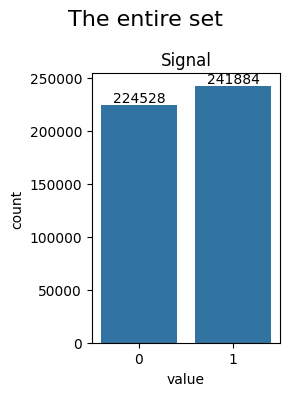

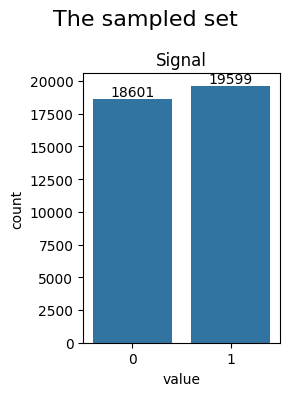

In [34]:
fig_a = plot_features_count(pd.DataFrame(y_train), ['signal'], figsize=(3,4), ncols=1, suptitle='The entire set')
fig_s = plot_features_count(pd.DataFrame(y_train_small), ['signal'], figsize=(3,4), ncols=1, suptitle='The sampled set')
display(fig_a, fig_s)

### Classifiers and hyperparameters.

Define a list of classifiers and hyperparameters to grid search over

In [35]:
sklearn_classifiers_t_r = [
    {
        'model':LogisticRegression, 
        'params': {
            'C': [1, 1.5], #[0.05, 0.1, 0.2, 0.5, 1, 1.2, 1.8],
            'solver': ['saga'], #['sag', 'saga', 'lbfgs', 'newton-cholesky'],
        }
    },
    {
        'model':GaussianNB, 
        'params': {
            'var_smoothing': [1e-11, 1e-09, 1e-06],
        }
    },
    {
        'model':RandomForestClassifier, 
        'params': {
            'max_depth': [2, None], 
        }
    },          

    {
        'model':HistGradientBoostingClassifier,
        'params': {
            'max_depth': [5, None], #[5, 10, 20, 50, None],
        }
    }
]

dim_reducers_t_r = [{'model': FastICA(), 'params': {'n_components': [2,5,8, None]}}, {'model': 'passthrough', 'params':{}}]

Define a list of train set lengths to grid search over 

In [36]:
train_set_lengths = [time_series_split_min_train_set, (time_series_split_max_train_set+time_series_split_min_train_set)//2, time_series_split_max_train_set]
#train_set_lengths = [100, 500]

### GridSearch

Run grid search on the list of classifiers.

In [37]:
results_file_t_r = os.path.join(pkl_dir, 'gridsearch_results_t_r.pkl')
grid_search_results_t_r = train_classifiers(results_file=results_file_t_r,
                                         classifiers=sklearn_classifiers_t_r,
                                         column_transformers=list(column_transformers.values()),
                                         configed_dim_reducers=dim_reducers_t_r,
                                         train_set_lengths=None, 
                                         X=X_train_small, y=y_train_small, 
                                         scoring=scorer, 
                                         cv=tscv_blocking,
)

load trained models from ../results/pickled\gridsearch_results_t_r.pkl
Model logisticregression:
With parameters: [{'logisticregression__C': [1, 1.5], 'logisticregression__solver': ['saga'], 'transformer': [ordinal_std_quantile_power_kbins_u, ordinal_std_quantile_power_kbins_q, ordinal_quantile_power_kbins_u, ordinal_quantile_power_kbins_q, ordinal_quantile_power, ordinal_no_transform_digit_cols, ordinal_max_abs_not_indicators, ordinal_standard_not_indicators, ordinal_standard, ordinal_standard_robust, ordinal_robust_not_indicators, target_std_quantile_power_kbins_u, target_std_quantile_power_kbins_q, target_quantile_power_kbins_u, target_quantile_power_kbins_q, target_quantile_power, target_no_transform_digit_cols, target_max_abs_not_indicators, target_standard_not_indicators, target_standard, target_standard_robust, target_robust_not_indicators, drop_std_quantile_power_kbins_u, drop_std_quantile_power_kbins_q, drop_quantile_power_kbins_u, drop_quantile_power_kbins_q, drop_quantile_po

### Analyze results 

Analyze results of grid search for different classifiers

In [38]:
score_file = os.path.join(results_dir,'ml_metrics_train.md')

def create_tables_of_best_scores(grid_search_results:list[dict]):
    for grid_search_result in grid_search_results:
        print(grid_search_result['name'])
        grid_search_result['scores_on_splits'], grid_search_result['best_estimator_scores'] = \
            cv_scores_on_splits(grid_search_result['grid_search'],scores=scores,confusion_matrix_cells=confusion_matrix_cells,n=2)
        
def save_scores_of_stage_to_file(grid_search_results:list[dict], stage:str, file_path:str=score_file):
    create_tables_of_best_scores(grid_search_results)
    with open(file_path, 'a', encoding='utf-8') as f: 
        f.write(f'\n\n## Stage: {stage} \n')
    scores_dfs = {f"{grid_search_result['name']}\n({grid_search_result['grid_search'].best_params_})\ntime: {grid_search_result['search_time']/60} min\n":
              grid_search_result['best_estimator_scores'] for grid_search_result in grid_search_results}
    add_data_frames_to_file(file_path, scores_dfs)

In [39]:
key_results_file = os.path.join(results_dir, 'key_results.md')
    
def save_grid_search_key_results(grid_search_results:list[dict], stage:str, file_path:str=key_results_file):
    """
    Save key results of grid search to a markdown file.
    Each grid search result will be saved with its parameters, best parameters, best score, and search time.
    """
    with open(file_path, 'a', encoding='utf-8') as f: 
        f.write(f'\n\n## Stage: {stage} \n')
        for grid_search_result in grid_search_results:
            param_grid = flatten_list_of_dicts(grid_search_result["grid_search"].param_grid)
             
            grid_search_result['key_results'] = pd.Series([
                param_grid, 
                grid_search_result["grid_search"].best_params_, 
                grid_search_result["grid_search"].best_score_, 
                grid_search_result["search_time"]/60],
                index=['Parameters grid', 'Best parameters', 'Best scores', 'Search time(min)'
            ])
            f.write(f'\n\n### {grid_search_result["name"]}\n')
            f.write(grid_search_result['key_results'].to_markdown())
            f.write('\n------------------------------------------------------------------------------------------------------')
    print(f'--- data is saved to {file_path} ---')

In [40]:
with open(key_results_file, 'w', encoding='utf-8') as f: 
    f.write('# Results of GridSearchCV\n')

save_grid_search_key_results(grid_search_results_t_r, 'Select transformer and dimention reducer')

--- data is saved to ../results/key_results.md ---


In [41]:
with open(score_file, 'w', encoding='utf-8') as f: 
    f.write('# Scores of best estimators chosen by GridSearchCV\n')

save_scores_of_stage_to_file(grid_search_results_t_r, 'Select transformer and dimention reducer')

logisticregression
gaussiannb
randomforestclassifier
histgradientboostingclassifier
Saving logisticregression
({'logisticregression...
Saving gaussiannb
({'gaussiannb__var_smoothing'...
Saving randomforestclassifier
({'randomforestcl...
Saving histgradientboostingclassifier
({'histgr...
--- data is saved to ../results/ml_metrics_train.md ---


In [42]:
for gs in grid_search_results_t_r:
    print(gs['grid_search'].cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_logisticregression__C', 'param_logisticregression__solver', 'param_reduce_dim', 'param_reduce_dim__n_components', 'param_transformer', 'params', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy', 'split9_test_accuracy', 'split10_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy', 'split1_train_accuracy', 'split2_train_accuracy', 'split3_train_accuracy', 'split4_train_accuracy', 'split5_train_accuracy', 'split6_train_accuracy', 'split7_train_accuracy', 'split8_train_accuracy', 'split9_train_accuracy', 'split10_train_accuracy', 'mean_train_accuracy', 'std_train_accuracy', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'split5_test_f1', 'split6_

In [43]:
accuracy_roc_file = os.path.join(results_dir,'ml_metrics_train_accuracy_roc.md')
with open(accuracy_roc_file, 'w', encoding='utf-8') as f: 
    f.write('## Select transformer and dimention reducer\n')
accuracy_dfs = {}
roc_auc_dfs = {}
split7_9 = {}
top_scores = {}
for grid_search_result in grid_search_results_t_r:
    name_ = grid_search_result['name']
    sets = grid_search_result['scores_on_splits'].index.get_level_values('set')
    accuracy_dfs[name_] = grid_search_result['scores_on_splits']['accuracy'][sets=='test'].dropna(how='all') 
    roc_auc_dfs[name_] = grid_search_result['scores_on_splits']['roc_auc'][sets=='test'].dropna(how='all')
    splits = grid_search_result['scores_on_splits'].index.get_level_values('split')
    split7_9[name_] = grid_search_result['scores_on_splits'][['accuracy','roc_auc']][(splits=='split7')|(splits=='split9')].dropna(how='all')
    top_scores[name_] = pd.concat([accuracy_dfs[name_].nlargest(5,keep='all'),roc_auc_dfs[name_].nlargest(5,keep='all')], axis='columns')
    top_scores[name_] = pd.concat([top_scores[name_],split7_9[name_]], axis='index')
#for model, df in top_scores.items():
    #print(f"Top scores for {model}:")
    #display(df)
add_data_frames_to_file(accuracy_roc_file, top_scores)

Saving logisticregression...
Saving gaussiannb...
Saving randomforestclassifier...
Saving histgradientboostingclassifier...
--- data is saved to ../results/ml_metrics_train_accuracy_roc.md ---


In [44]:
weigths_split7_file = os.path.join(results_dir,'scores_on_split7.md')
with open(weigths_split7_file, 'w', encoding='utf-8') as f: 
    f.write('## Stage 1\n')
distr_weight_on_split7 = {}
for grid_search_result in grid_search_results_t_r:
    model_name = grid_search_result['name']
    distr_weight_on_split7[model_name] = cv_scores_on_splits_per_param(grid_search_result['grid_search'], par_name=f'{model_name}__class_weight',  scores='roc_auc', splits=7)
add_data_frames_to_file(weigths_split7_file, distr_weight_on_split7)

Saving logisticregression...
Saving gaussiannb...
Saving randomforestclassifier...
Saving histgradientboostingclassifier...
--- data is saved to ../results/scores_on_split7.md ---


In [45]:
def concatenate_estimators_scores(grid_search_results, score_key='best_estimator_scores'):
    dfs = []
    for grid_search_result in grid_search_results:
        df = grid_search_result[score_key].copy()
        df['Model name'] = grid_search_result['name']
        dfs.append(df)
    return pd.concat(dfs)

In [46]:
rocauc_by_splits_t_r_file = os.path.join(results_dir,'best_models_scores_roc_auc_t_r.png')
snsplot = lineplot(concatenate_estimators_scores(grid_search_results_t_r).reset_index(), x='split',  y='roc_auc',style='set',title='Compare ROC_AUC of the best models') 
snsplot.figure.savefig(rocauc_by_splits_t_r_file)
print('ROC_AUC scores of the best models are saved into ', paint(rocauc_by_splits_t_r_file, format))

ROC_AUC scores of the best models are saved into  ../results/best_models_scores_roc_auc_t_r.png


In [47]:
def create_tables_of_scores_by_param(grid_search_results, par_names, key, score='roc_auc'):
    """
    Used to create a table of scores by parameters' values for each grid search result.
    """
    def define_param_name(grid_search_result, par_name):
        if par_name in flatten_list_of_dicts(grid_search_result['grid_search'].param_grid):
            return par_name
        else:
            return f'{grid_search_result["name"]}__{par_name}'
        
    def get_best_params_value(grid_search_result, param_name):
        best_params_ = grid_search_result['grid_search'].best_params_
        if param_name not in best_params_:
            return "-"
        sub_params = {name_.split('__')[-1]: value for name_, value in best_params_.items() if f'{param_name}__' in name_}
        if not sub_params:
            res_str =  f"{best_params_[param_name]}"
        else:
            res_str =  f"{best_params_[param_name]} ({sub_params})"
        return res_str

    best_params = {}
    for grid_search_result in grid_search_results:
        model_name = grid_search_result['name']
        if isinstance(par_names, str):
            param_name = define_param_name(grid_search_result, par_names)
            grid_search_result[key] = cv_scores(grid_search_result['grid_search'], score=score, par_names=param_name)
            best_params[model_name] = get_best_params_value(grid_search_result, param_name)
        else:
            param_names = [define_param_name(grid_search_result, par_name) for par_name in par_names]
            grid_search_result[key] = cv_scores_per_params(grid_search_result['grid_search'], score=score, par_names=param_names)
            best_params[model_name] = {par_name: get_best_params_value(grid_search_result, par_name) for par_name in param_names}

    
    res_df = concatenate_estimators_scores(grid_search_results, score_key=key)
    
    return res_df, best_params

def print_scores_by_param(res_df, best_params, title, score='roc_auc', param_values_prune=None, model_names_prune=None ):
    print(f'****Splitwise mean of {color}{score}{del_format} scores for each {title} and the best value for the other parametrs****\n')
    for model_name, best_param in best_params.items():
        print(f"Best parameters: {paint(model_name, format)}: {best_param}")
    print('\n========================================================================================================')

    to_print_df = res_df.pivot(columns='Model name').swaplevel(axis='columns').sort_index(axis='columns', level=0, sort_remaining=False)
    to_print_df = to_print_df.rename(columns=lambda x: x[:model_names_prune], level='Model name')
    to_print_df = to_print_df.rename(index=lambda x: x[:param_values_prune] if isinstance(x, str) else x)
    print(to_print_df)

In [48]:
transformer_comparation, best_transformers = create_tables_of_scores_by_param(grid_search_results_t_r, par_names='transformer', key='scores_by_transformers')
print_scores_by_param(transformer_comparation, best_transformers, 'transformer', model_names_prune=10, param_values_prune=None)

****Splitwise mean of roc_auc scores for each transformer and the best value for the other parametrs****

Best parameters: logisticregression: drop_standard_not_indicators
Best parameters: gaussiannb: ordinal_standard_not_indicators
Best parameters: randomforestclassifier: drop_standard_robust
Best parameters: histgradientboostingclassifier: ordinal_no_transform_digit_cols

Model name                         gaussiannb           histgradie            \
                                        train      test      train      test   
drop_max_abs_not_indicators          0.511852  0.508805   0.585714  0.509561   
drop_no_transform_digit_cols         0.511625  0.514348   0.577601  0.510335   
drop_quantile_power                  0.515086  0.512573   0.600021  0.499905   
drop_quantile_power_kbins_q          0.517028  0.514295   0.587545  0.517972   
drop_quantile_power_kbins_u          0.517525  0.513803   0.584491  0.507029   
drop_robust_not_indicators           0.510540  0.517647   0.578

In [49]:
par_names = {f'reduce_dim__{param_name}' for dim_reducer in dim_reducers_t_r for param_name in dim_reducer['params'].keys() }
reducer_comparation, best_reducer = create_tables_of_scores_by_param(grid_search_results_t_r, par_names=['reduce_dim',*par_names], key='scores_by_dim_reducers')
print_scores_by_param(reducer_comparation, best_reducer, 'dimention reducer', model_names_prune=10)

****Splitwise mean of roc_auc scores for each dimention reducer and the best value for the other parametrs****

Best parameters: logisticregression: {'reduce_dim': "FastICA() ({'n_components': 2})", 'reduce_dim__n_components': '2'}
Best parameters: gaussiannb: {'reduce_dim': "FastICA() ({'n_components': 5})", 'reduce_dim__n_components': '5'}
Best parameters: randomforestclassifier: {'reduce_dim': 'passthrough', 'reduce_dim__n_components': '-'}
Best parameters: histgradientboostingclassifier: {'reduce_dim': "FastICA() ({'n_components': 5})", 'reduce_dim__n_components': '5'}

Model name                           gaussiannb           histgradie  \
                                          train      test      train   
reduce_dim  reduce_dim__n_components                                   
FastICA()   2                          0.512353  0.521555   0.554066   
            5                          0.514097  0.523111   0.573388   
            8                          0.517087  0.518174  

In [50]:
def plot_validation_by(df_to_plot, by, score_to_plot='roc_auc', hue='Model name', figsize=(11, 4), rotation_ticks=False):
    value_vars=['train', 'test']
    id_vars=[c for c in df_to_plot.columns if c not in value_vars]
    df_to_plot = df_to_plot.melt(id_vars=id_vars, value_vars=value_vars, var_name='set', value_name=score_to_plot)
    snsplot = lineplot(df_to_plot, x=by,  y=score_to_plot, style='set', hue=hue, title=f'{score_to_plot} by {by}s', figsize=figsize, rotation_ticks=rotation_ticks) 
    return snsplot

In [51]:
rocauc_by_splits_t_r_file = os.path.join(results_dir,'roc_auc_t_r.pdf')
# plot by splits
snsplot_split = lineplot(concatenate_estimators_scores(grid_search_results_t_r), x='split',  y='roc_auc',style='set',title='Compare ROC_AUC of the best models', figsize=(11, 4)) 

#plot by transformers
by='transformer'
#renamer_transformers = {str(name): name.__class__.__name__.rstrip('DigitCols').replace('Indicator','Indic') for name in column_transformers}
df_to_plot = transformer_comparation.reset_index(names=by)
snsplot_transformer = plot_validation_by(df_to_plot, by=by, rotation_ticks=True) 

#plot by reducers
by='reducer'
df_to_plot = reducer_comparation.reset_index()
df_to_plot[by]=df_to_plot['reduce_dim'].astype(str) + '_' + df_to_plot['reduce_dim__n_components'].astype(str).str.split(' ').str[-1]
snsplot_reducer = plot_validation_by(df_to_plot, by=by) 

with PdfPages(rocauc_by_splits_t_r_file) as pdf:
    snsplot_split.figure.savefig(pdf, format='pdf')
    snsplot_transformer.figure.savefig(pdf, format='pdf')
    snsplot_reducer.figure.savefig(pdf, format='pdf')
print('plot of ROC_AUC scores are saved into ', paint(rocauc_by_splits_t_r_file, format))

plot of ROC_AUC scores are saved into  ../results/roc_auc_t_r.pdf


## Cross validation with 25 folds

### Build cross validation

In [52]:
validation_set_size_11=11
n_splits_11=25

tscv_blocking_11 = MultiTimeSeriesSplit(n_splits=n_splits_11, 
                                     max_train_size=max_train_size, 
                                     min_train_size=days_in_2years_history, 
                                     test_size=validation_set_size_11, 
                                     gap=0)

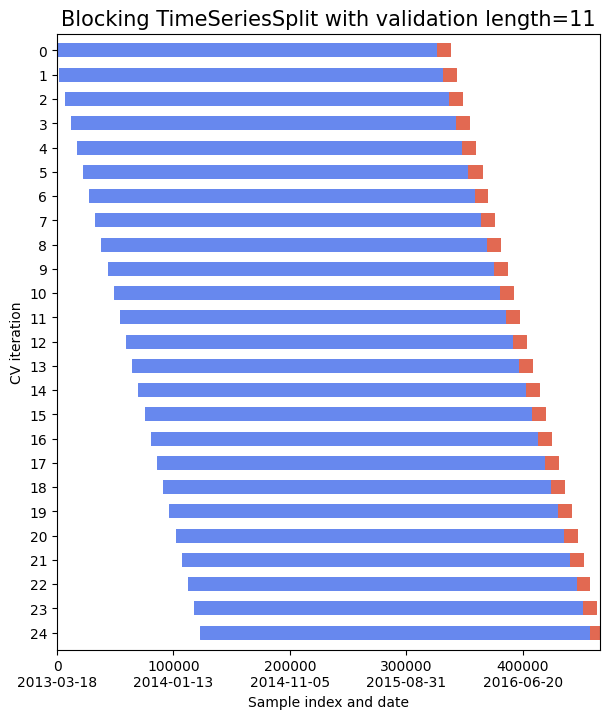

In [53]:
fig = plot_cv(tscv_blocking_11, f'Blocking TimeSeriesSplit with validation length={validation_set_size_11}', X_train, y_train, scale_x=500, figsize=(7, 8))   
display(fig)

In [54]:
print(f'Minimum length of the train sets {paint('(number of days)',format)} in the cross-validation above: {paint(tscv_blocking_11.get_min_train_size(), format)}')
print(f'Length of train folds, companies in the fold:')
i = 0
end=' -> '
for train_idxs, _ in tscv_blocking_11.split(X_train):
    if i == n_splits_11-1:
        end = '\n'
    print(f'{i}: {len(X_train.iloc[train_idxs])}, {len(X_train.iloc[train_idxs]['Name'].unique())}', end=end)
    i += 1

Minimum length of the train sets (number of days) in the cross-validation above: 504
Length of train folds, companies in the fold:
0: 329822, 494 -> 1: 330020, 494 -> 2: 330222, 495 -> 3: 330435, 495 -> 4: 330644, 495 -> 5: 330857, 496 -> 6: 331074, 496 -> 7: 331283, 496 -> 8: 331491, 496 -> 9: 331653, 496 -> 10: 331807, 496 -> 11: 331967, 497 -> 12: 332141, 497 -> 13: 332306, 497 -> 14: 332471, 497 -> 15: 332636, 497 -> 16: 332802, 498 -> 17: 332978, 498 -> 18: 333152, 498 -> 19: 333317, 498 -> 20: 333482, 498 -> 21: 333647, 498 -> 22: 333812, 498 -> 23: 333977, 498 -> 24: 334142, 498


In [55]:
print(f'Do the train and test folds contain data from the same day: {paint(is_train_test_folds_have_common_dates(tscv_blocking, X_train), format)}')

Do the train and test folds contain data from the same day: False


### Classifiers and hyperparameters.

Define a list of classifiers and hyperparameters to grid search over

In [56]:
sklearn_classifiers_cv = [
    {
        'model':LogisticRegression, 
        'params': {
            'C': [1.5], #[0.05, 0.1, 0.2, 0.5, 1, 1.2, 1.8],
            'solver': ['saga'], #['sag', 'saga', 'lbfgs', 'newton-cholesky'],
        }
    },
    {
        'model':GaussianNB, 
        'params': {
            'var_smoothing': [1e-11, 1e-06],
        }
    },
    {
        'model':RandomForestClassifier, 
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [2], 
        }
    },          
    {
        'model':HistGradientBoostingClassifier,
        'params': {
            'max_depth': [10, None], #[5, 10, 20, 50, None],
        }
    }
]


In [57]:

kbins_uniform_20 = KBinsDiscretizer(n_bins=20, strategy='uniform')
kbins_quantile_20 = KBinsDiscretizer(n_bins=20, strategy='quantile')
kbins_u20 = [NamedTransformer(name='ordinal_std_quantile_power_kbins_u20', 
                              transformer=EncoderNameScalerDigitCols(
                                  transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                        (power_transforemer, power_transformer_cols), 
                                                        (kbins_uniform_20, kbins_discretizer_cols), 
                                                        (quantile_transformer, quantile_transformer_cols)], 
                                  encoder=ordinal_encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas'),
             NamedTransformer(name='ordinal_quantile_power_kbins_u20', 
                              transformer=EncoderNameScalerDigitCols(
                                  transformers_columns=[(power_transforemer, power_transformer_cols), 
                                                        (kbins_uniform_20, kbins_discretizer_cols), 
                                                        (quantile_transformer,standard_scaling_cols+quantile_transformer_cols)], 
                                  encoder=ordinal_encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')]
kbins_q20 = [NamedTransformer(name='ordinal_std_quantile_power_kbins_q20', 
                              transformer=EncoderNameScalerDigitCols(
                                  transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                        (power_transforemer, power_transformer_cols), 
                                                        (kbins_quantile_20, kbins_discretizer_cols), 
                                                        (quantile_transformer, quantile_transformer_cols)], 
                                  encoder=ordinal_encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas'),
             NamedTransformer(name='ordinal_quantile_power_kbins_q20', 
                              transformer=EncoderNameScalerDigitCols(
                                  transformers_columns=[(power_transforemer, power_transformer_cols), 
                                                        (kbins_quantile_20, kbins_discretizer_cols), 
                                                        (quantile_transformer,standard_scaling_cols+quantile_transformer_cols)], 
                                  encoder=ordinal_encoder, verbose_feature_names_out=False
                )).set_output(transform='pandas')]


scaler_continuoses = ColumnTransformer([('std_scaler', std_scaler, standard_scaling_cols+quantile_transformer_cols+power_transformer_cols)], 
                        verbose_feature_names_out=False, remainder='passthrough').set_output(transform='pandas')
column_transformers_cv = {'logisticregression': [column_transformers['ordinal_std_quantile_power_kbins_u'],
                                                 column_transformers['ordinal_quantile_power_kbins_u'],
                                                 *kbins_u20],
                          'gaussiannb': [column_transformers['target_standard']],
                          'randomforestclassifier': [column_transformers['ordinal_std_quantile_power_kbins_q'],
                                                    column_transformers['ordinal_quantile_power_kbins_q'],
                                                    *kbins_q20,],
                          'histgradientboostingclassifier': [column_transformers['ordinal_std_quantile_power_kbins_u'], 
                                                             kbins_u20[0]],
                          }
for name_, transformers in column_transformers_cv.items():
    if name_ != 'gaussiannb':
        transform_scales = [NamedTransformer(name=f'{transformer}_scl', transformer=Pipeline([('transformer', transformer), ('scaler', scaler_continuoses)])) 
                       for transformer in transformers]
        transformers += transform_scales

dim_reducers_cv = [{'model': FastICA(), 'params': {'n_components': [2]}}]

Define a list of train set lengths to grid search over 

In [58]:
train_set_lengths_cv = [days_in_2years_history*n_orgs_small, (days_in_2years_history+max_train_size)*n_orgs_small//2, max_train_size*n_orgs_small]

In [59]:
train_set_lengths_cv

[20160, 23680, 27200]

### GridSearch

Run grid search on the list of classifiers.

In [60]:
results_file_cv = os.path.join(pkl_dir, 'gridsearch_results_cv.pkl')
grid_search_results_cv = train_classifiers(results_file=results_file_cv,
                                         classifiers=sklearn_classifiers_cv,
                                         column_transformers=column_transformers_cv,
                                         configed_dim_reducers=dim_reducers_cv,
                                         train_set_lengths=train_set_lengths_cv, 
                                         X=X_train_small, y=y_train_small, 
                                         scoring=scorer, 
                                         cv=tscv_blocking_11,
)

load trained models from ../results/pickled\gridsearch_results_cv.pkl
Model logisticregression:
With parameters: [{'logisticregression__C': [1.5], 'logisticregression__solver': ['saga'], 'logisticregression__train_length': [20160, 23680, 27200], 'transformer': [ordinal_std_quantile_power_kbins_u, ordinal_quantile_power_kbins_u, ordinal_std_quantile_power_kbins_u20, ordinal_quantile_power_kbins_u20, ordinal_std_quantile_power_kbins_u_scl, ordinal_quantile_power_kbins_u_scl, ordinal_std_quantile_power_kbins_u20_scl, ordinal_quantile_power_kbins_u20_scl], 'reduce_dim': [FastICA()], 'reduce_dim__n_components': [2]}]

Best parameters: {'logisticregression__C': 1.5, 'logisticregression__solver': 'saga', 'logisticregression__train_length': 27200, 'reduce_dim': FastICA(), 'reduce_dim__n_components': 2, 'transformer': ordinal_quantile_power_kbins_u20}
Best scores: 0.5169104195029943
Search time: 4.94327813500034 minutes
Model gaussiannb:
With parameters: [{'gaussiannb__var_smoothing': [1e-11, 1

### Analyze results 

Analyze results of grid search for different classifiers

In [61]:
# TODO make a function to do analysis of the results (params: grid_search_results, stage_name,estiamators and params to compare; params to plot - get from params to compare; file_path make from grid_search_results variable name)
save_grid_search_key_results(grid_search_results_cv, 'CV 25 folds, 11 days validation')
save_scores_of_stage_to_file(grid_search_results_cv, 'CV 25 folds, 11 days validation')

--- data is saved to ../results/key_results.md ---
logisticregression
gaussiannb
randomforestclassifier
histgradientboostingclassifier
Saving logisticregression
({'logisticregression...
Saving gaussiannb
({'gaussiannb__train_length':...
Saving randomforestclassifier
({'randomforestcl...
Saving histgradientboostingclassifier
({'histgr...
--- data is saved to ../results/ml_metrics_train.md ---


In [62]:
with open(accuracy_roc_file, 'a', encoding='utf-8') as f: 
    f.write('## CV 25 folds, 11 days validation\n')
accuracy_dfs = {}
roc_auc_dfs = {}
split7_9 = {}
top_scores = {}
for grid_search_result in grid_search_results_cv:
    name_ = grid_search_result['name']
    sets = grid_search_result['scores_on_splits'].index.get_level_values('set')
    accuracy_dfs[name_] = grid_search_result['scores_on_splits']['accuracy'][sets=='test'].dropna(how='all') 
    roc_auc_dfs[name_] = grid_search_result['scores_on_splits']['roc_auc'][sets=='test'].dropna(how='all')
    splits = grid_search_result['scores_on_splits'].index.get_level_values('split')
    split7_9[name_] = grid_search_result['scores_on_splits'][['accuracy','roc_auc']][(splits=='split7')|(splits=='split9')].dropna(how='all')
    top_scores[name_] = pd.concat([accuracy_dfs[name_].nlargest(5,keep='all'),roc_auc_dfs[name_].nlargest(5,keep='all')], axis='columns')
    top_scores[name_] = pd.concat([top_scores[name_],split7_9[name_]], axis='index')
#for model, df in top_scores.items():
    #print(f"Top scores for {model}:")
    #display(df)
add_data_frames_to_file(accuracy_roc_file, top_scores)

Saving logisticregression...
Saving gaussiannb...
Saving randomforestclassifier...
Saving histgradientboostingclassifier...
--- data is saved to ../results/ml_metrics_train_accuracy_roc.md ---


In [63]:
comparation_table = create_comparation_table([grid_search_results_t_r, grid_search_results_cv, ],
                          ['transf-scaler', 'CV', ],
                          [res['name'] for res in grid_search_results_cv], 
                          ['score', 'transformer', 'reduce_dim'])
comparation_table#[comparation_table['diff'] != 'Same']

transf-scaler  \
model                          param                                                 
gaussiannb                     reduce_dim                                 FasICA()   
                               score                                      0.523111   
                               train_length_best                               NaN   
                               train_length_grid                               NaN   
                               transformer         ordinal_standard_not_indicators   
                               var_smoothing_best                            1e-11   
                               var_smoothing_grid            [1e-11, 1e-09, 1e-06]   
histgradientboostingclassifier max_depth_best                                    5   
                               max_depth_grid                            [5, None]   
                               reduce_dim                                 FasICA()   
                               score                                         0.525   
                               train_length_best                               NaN   
                               train_length_grid                               NaN   
                               transformer         ordinal_no_transform_digit_cols   
logisticregression             C_best                                          1.5   
                               C_grid                                     [1, 1.5]   
                               reduce_dim                                 FasICA()   
                               score                                      0.519968   
                               solver_best                                    saga   
                               solver_grid                                ['saga']   
                               train_length_best                               NaN   
                               train_length_grid                               NaN   
                               transformer            drop_standard_not_indicators   
randomforestclassifier         max_depth_best                                    2   
                               max_depth_grid                            [2, None]   
                               n_estimators_best                               NaN   
                               n_estimators_grid                               NaN   
                               reduce_dim                              passthrough   
                               score                                      0.524476   
                               train_length_best                               NaN   
                               train_length_grid                               NaN   
                               transformer                    drop_standard_robust   

                                                                                         CV  \
model                          param                                                          
gaussiannb                     reduce_dim                                          FasICA()   
                               score                                               0.518798   
                               train_length_best                                      27200   
                               train_length_grid                      [20160, 23680, 27200]   
                               transformer                                  target_standard   
                               var_smoothing_best                                     1e-11   
                               var_smoothing_grid                            [1e-11, 1e-06]   
histgradientboostingclassifier max_depth_best                                          None   
                               max_depth_grid                                    [10, None]   
                               reduce_dim                                          FasICA()   
    

In [64]:
transformer_comparation, best_transformers = create_tables_of_scores_by_param(grid_search_results_cv, par_names='transformer', key='scores_by_transformers')
print_scores_by_param(transformer_comparation, best_transformers, 'transformer', model_names_prune=10, param_values_prune=None)

****Splitwise mean of roc_auc scores for each transformer and the best value for the other parametrs****

Best parameters: logisticregression: ordinal_quantile_power_kbins_u20
Best parameters: gaussiannb: target_standard
Best parameters: randomforestclassifier: ordinal_std_quantile_power_kbins_q20
Best parameters: histgradientboostingclassifier: ordinal_std_quantile_power_kbins_u20_scl

Model name                               gaussiannb           histgradie  \
                                              train      test      train   
ordinal_quantile_power_kbins_q                  NaN       NaN        NaN   
ordinal_quantile_power_kbins_q20                NaN       NaN        NaN   
ordinal_quantile_power_kbins_q20_scl            NaN       NaN        NaN   
ordinal_quantile_power_kbins_q_scl              NaN       NaN        NaN   
ordinal_quantile_power_kbins_u                  NaN       NaN        NaN   
ordinal_quantile_power_kbins_u20                NaN       NaN        NaN   
or

In [65]:
train_length_comparation, best_train_length = create_tables_of_scores_by_param(grid_search_results_cv, par_names='train_length', key='scores_by_train_length')
print_scores_by_param(train_length_comparation, best_train_length, 'train_length', model_names_prune=10)

****Splitwise mean of roc_auc scores for each train_length and the best value for the other parametrs****

Best parameters: logisticregression: 27200
Best parameters: gaussiannb: 27200
Best parameters: randomforestclassifier: 23680
Best parameters: histgradientboostingclassifier: 27200

Model name gaussiannb           histgradie           logisticre            \
                train      test      train      test      train      test   
20160        0.509639  0.516006   0.565229  0.508517   0.512404  0.515062   
23680        0.510865  0.516313   0.571231  0.511767   0.512580  0.515962   
27200        0.511978  0.518798   0.579590  0.515096   0.512675  0.516910   

Model name randomfore            
                train      test  
20160        0.525601  0.516121  
23680        0.526618  0.522328  
27200        0.527630  0.518849  


In [66]:
rocauc_by_splits_cv_file = os.path.join(results_dir,'roc_auc_cv.pdf')
# plot by splits
snsplot_split = lineplot(concatenate_estimators_scores(grid_search_results_cv), x='split',  y='roc_auc',style='set',title='Compare ROC_AUC of the best models', figsize=(11, 4)) 


#plot by transformer
by='transformer'
def renamer_transformers(s):
    letters = [word[0] for word in s.split('_')]
    if s[-2:].isdigit():
        letters.append(s[-2:])
    return ''.join(letters)
df_to_plot = transformer_comparation.rename(index=renamer_transformers).reset_index(names=by)
snsplot_transformer = plot_validation_by(df_to_plot, by=by) 
#plot by train_length
by='train_length'
df_to_plot = train_length_comparation.reset_index(names=by)
snsplot_train_length = plot_validation_by(df_to_plot, by=by) 
with PdfPages(rocauc_by_splits_cv_file) as pdf:
    snsplot_split.figure.savefig(pdf, format='pdf')
    snsplot_transformer.figure.savefig(pdf, format='pdf')
    snsplot_train_length.figure.savefig(pdf, format='pdf')
print('plot of ROC_AUC scores are saved into ', paint(rocauc_by_splits_cv_file, format))

plot of ROC_AUC scores are saved into  ../results/roc_auc_cv.pdf


## GridSearch RandomForestClassifier and LogisticRegression

### Classifiers and hyperparameters.

In [67]:
configer_classifier_cls=[
    {
        'model':LogisticRegression, 
        'params': {
            'C': [0.5, 1, 1.5, 1.8, 2],
            'solver': ['sag', 'saga', 'lbfgs', 'newton-cholesky', 'newton-cg'],
            'max_iter': [100, 200],
        }
    },
    {
        'model':SGDClassifier, 
        'params': {
            'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error'],
            'penalty': ['l2', 'l1', 'elasticnet'],
        }
    },
    {
        'model':RandomForestClassifier, 
        'params': {
            'n_estimators': [100, 150, 200],
            'min_samples_split': [2, 3, 4], 
            'min_samples_leaf': [1, 2, 3], 
            'max_features': ["sqrt", "log2", None],
            'max_depth': [2, 3],
        }
    },
]
column_transformers_cls = {'logisticregression': column_transformers['ordinal_std_quantile_power_kbins_u'],
                          'randomforestclassifier': column_transformers['ordinal_std_quantile_power_kbins_q'],
                          'sgdclassifier': column_transformers['ordinal_std_quantile_power_kbins_u'],
                        }

dim_reducers_cls = {'model': FastICA(), 'params': {'n_components': [2]}}
n_orgs_train = X_train['Name'].nunique()
lenght_start = (days_in_2years_history)*n_orgs_train
lenght_end = max_train_size * n_orgs_train
length_diff = lenght_end - lenght_start
train_set_lengths_cls = [length+2 for length in range(lenght_start, lenght_end, length_diff//3)]
train_set_lengths_cls.append(lenght_end)

In [68]:
train_set_lengths_cls

[250994, 280210, 309426, 338640]

### GridSearch

In [69]:
results_file_cls= os.path.join(pkl_dir,'gridsearch_results_cls.pkl' )
grid_search_results_cls = train_classifiers(results_file=results_file_cls,
                                         classifiers=configer_classifier_cls,
                                         column_transformers=column_transformers_cls,
                                         configed_dim_reducers=dim_reducers_cls,
                                         train_set_lengths=train_set_lengths_cls,
                                         X=X_train, y=y_train,
                                         scoring=scorer, 
                                         cv=tscv_blocking,
                                         error_score='raise',
)

load trained models from ../results/pickled\gridsearch_results_cls.pkl
Model logisticregression:
With parameters: {'logisticregression__C': [0.5, 1, 1.5, 1.8, 2], 'logisticregression__solver': ['sag', 'saga', 'lbfgs', 'newton-cholesky', 'newton-cg'], 'logisticregression__max_iter': [100, 200], 'logisticregression__train_length': [250994, 280210, 309426, 338640], 'reduce_dim__n_components': [2]}

Best parameters: {'logisticregression__C': 1, 'logisticregression__max_iter': 100, 'logisticregression__solver': 'saga', 'logisticregression__train_length': 338640, 'reduce_dim__n_components': 2}
Best scores: 0.529169836068199
Search time: 156.8787384399989 minutes
Model sgdclassifier:
With parameters: {'sgdclassifier__loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error'], 'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet'], 'sgdclassifier__train_length': [250994, 280210, 309426, 338640], 'reduce_dim__n_components': [2]}

Best parameters: {'reduce_dim__

### Analyze results

In [70]:
save_grid_search_key_results(grid_search_results_cls, 'Choose hyperparameters')
save_scores_of_stage_to_file(grid_search_results_cls, 'Choose hyperparameters')

--- data is saved to ../results/key_results.md ---
logisticregression
sgdclassifier
randomforestclassifier
Saving logisticregression
({'logisticregression...
Saving sgdclassifier
({'reduce_dim__n_component...
Saving randomforestclassifier
({'randomforestcl...
--- data is saved to ../results/ml_metrics_train.md ---


In [71]:
with open(accuracy_roc_file, 'a', encoding='utf-8') as f: 
    f.write('## Choose hyperparameters\n')
accuracy_dfs = {}
roc_auc_dfs = {}
split7_9 = {}
top_scores = {}
for grid_search_result in grid_search_results_cls:
    name_ = grid_search_result['name']
    sets = grid_search_result['scores_on_splits'].index.get_level_values('set')
    accuracy_dfs[name_] = grid_search_result['scores_on_splits']['accuracy'][sets=='test'].dropna(how='all') 
    roc_auc_dfs[name_] = grid_search_result['scores_on_splits']['roc_auc'][sets=='test'].dropna(how='all')
    splits = grid_search_result['scores_on_splits'].index.get_level_values('split')
    split7_9[name_] = grid_search_result['scores_on_splits'][['accuracy','roc_auc']][(splits=='split7')|(splits=='split9')].dropna(how='all')
    top_scores[name_] = pd.concat([accuracy_dfs[name_].nlargest(5,keep='all'),roc_auc_dfs[name_].nlargest(5,keep='all')], axis='columns')
    top_scores[name_] = pd.concat([top_scores[name_],split7_9[name_]], axis='index')
#for model, df in top_scores.items():
    #print(f"Top scores for {model}:")
    #display(df)
add_data_frames_to_file(accuracy_roc_file, top_scores)

Saving logisticregression...
Saving sgdclassifier...
Saving randomforestclassifier...
--- data is saved to ../results/ml_metrics_train_accuracy_roc.md ---


In [72]:
comparation_table = create_comparation_table([grid_search_results_t_r, grid_search_results_cv, grid_search_results_cls],
                          ['transf-scaler', 'CV', 'hyperparams'],
                          ['logisticregression', 'randomforestclassifier',], 
                          ['score', 'transformer', ])
comparation_table#[comparation_table['diff'] != 'Same']

transf-scaler  \
model                  param                                                  
logisticregression     C_best                                           1.5   
                       C_grid                                      [1, 1.5]   
                       max_iter_best                                    NaN   
                       max_iter_grid                                    NaN   
                       score                                       0.519968   
                       solver_best                                     saga   
                       solver_grid                                 ['saga']   
                       train_length_best                                NaN   
                       train_length_grid                                NaN   
                       transformer             drop_standard_not_indicators   
randomforestclassifier max_depth_best                                     2   
                       max_depth_grid                             [2, None]   
                       max_features_best                                NaN   
                       max_features_grid                                NaN   
                       min_samples_leaf_best                            NaN   
                       min_samples_leaf_grid                            NaN   
                       min_samples_split_best                           NaN   
                       min_samples_split_grid                           NaN   
                       n_estimators_best                                NaN   
                       n_estimators_grid                                NaN   
                       score                                       0.524476   
                       train_length_best                                NaN   
                       train_length_grid                                NaN   
                       transformer                     drop_standard_robust   

                                                                                 CV  \
model                  param                                                          
logisticregression     C_best                                                   1.5   
                       C_grid                                                 [1.5]   
                       max_iter_best                                            NaN   
                       max_iter_grid                                            NaN   
                       score                                                0.51691   
                       solver_best                                             saga   
                       solver_grid                                         ['saga']   
                       train_length_best                                      27200   
                       train_length_grid                      [20160, 23680, 27200]   
                       transformer                 ordinal_quantile_power_kbins_u20   
randomforestclassifier max_depth_best                                             2   
                       max_depth_grid                                           [2]   
                       max_features_best                                        NaN   
                       max_features_grid                                        NaN   
                       min_samples_leaf_best                                    NaN   
                       min_samples_leaf_grid                                    NaN   
                       min_samples_split_best                                   NaN   
                       min_samples_split_grid                                   NaN   
                       n_estimators_best                                        100   
                       n_estimators_grid                                  [50, 100]   
                       score                                               0.522328   
      

In [73]:
train_length_comparation, best_train_length = create_tables_of_scores_by_param(grid_search_results_cls, par_names='train_length', key='scores_by_train_length')
print_scores_by_param(train_length_comparation, best_train_length, 'train_length', model_names_prune=10)

****Splitwise mean of roc_auc scores for each train_length and the best value for the other parametrs****

Best parameters: logisticregression: 338640
Best parameters: sgdclassifier: 280210
Best parameters: randomforestclassifier: 280210

Model name logisticre           randomfore           sgdclassif          
                train      test      train      test      train      test
250994       0.513448  0.528850   0.514357  0.529010   0.508485  0.517017
280210       0.513462  0.529004   0.514471  0.530144   0.513460  0.529157
309426       0.513470  0.529059   0.514327  0.529457   0.511279  0.524661
338640       0.513469  0.529170   0.514173  0.529146   0.511079  0.527931


In [74]:
min_samples_leaf_comparation, best_min_samples_leaf = create_tables_of_scores_by_param([grid_search_results_cls[2]], par_names='min_samples_leaf', key='scores_by_min_samples_leaf')
print_scores_by_param(min_samples_leaf_comparation, best_min_samples_leaf, 'min_samples_leaf', model_names_prune=10)

****Splitwise mean of roc_auc scores for each min_samples_leaf and the best value for the other parametrs****

Best parameters: randomforestclassifier: 3

Model name randomfore          
                train      test
1            0.514348  0.529695
2            0.514424  0.529455
3            0.514471  0.530144


In [75]:
n_estimators_comparation, best_n_estimators = create_tables_of_scores_by_param([grid_search_results_cls[2]], par_names='n_estimators', key='scores_by_n_estimators')
print_scores_by_param(n_estimators_comparation, best_n_estimators, 'n_estimators', model_names_prune=10)

****Splitwise mean of roc_auc scores for each n_estimators and the best value for the other parametrs****

Best parameters: randomforestclassifier: 100

Model name randomfore          
                train      test
100          0.514471  0.530144
150          0.514415  0.529740
200          0.514532  0.529705


In [76]:
max_features_comparation, best_max_features = create_tables_of_scores_by_param([grid_search_results_cls[2]], par_names='max_features', key='scores_by_max_features')
print_scores_by_param(max_features_comparation, best_max_features, 'max_features', model_names_prune=10)

****Splitwise mean of roc_auc scores for each max_features and the best value for the other parametrs****

Best parameters: randomforestclassifier: None

Model name randomfore          
                train      test
None         0.514471  0.530144
log2         0.515179  0.528984
sqrt         0.515060  0.528584


In [77]:
rocauc_by_splits_cls_file = os.path.join(results_dir,'roc_auc_cls.pdf')
# plot by splits
snsplot_split = lineplot(concatenate_estimators_scores(grid_search_results_cls), x='split',  y='roc_auc',style='set',title='Compare ROC_AUC of the best models', figsize=(11, 4)) 


#plot by train_length
by='train_length'
df_to_plot = train_length_comparation.reset_index(names=by)
snsplot_train_length = plot_validation_by(df_to_plot, by=by) 
#plot by min_samples_leaf
by='min_samples_leaf'
df_to_plot = min_samples_leaf_comparation.reset_index(names=by)
snsplot_min_samples_leaf = plot_validation_by(df_to_plot, by=by) 
#plot by n_estimators
by='n_estimators'
df_to_plot = n_estimators_comparation.reset_index(names=by)
snsplot_n_estimators = plot_validation_by(df_to_plot, by=by) 
#plot by max_features
by='max_features'
df_to_plot = max_features_comparation.reset_index(names=by)
snsplot_max_features = plot_validation_by(df_to_plot, by=by) 
with PdfPages(rocauc_by_splits_cls_file) as pdf:
    snsplot_split.figure.savefig(pdf, format='pdf')
    snsplot_train_length.figure.savefig(pdf, format='pdf')
    snsplot_min_samples_leaf.figure.savefig(pdf, format='pdf')
    snsplot_n_estimators.figure.savefig(pdf, format='pdf')
    snsplot_max_features.figure.savefig(pdf, format='pdf')
print('plot of ROC_AUC scores are saved into ', paint(rocauc_by_splits_cls_file, format))

plot of ROC_AUC scores are saved into  ../results/roc_auc_cls.pdf


### Plot validation curves

Get data for validation_curve

In [78]:
for grid_search_result in grid_search_results_cls:
    grid_search_result['validation_curve_data'] = cv_scores(grid_search_result['grid_search'], score='roc_auc')

#### Plot validation curves

In [79]:
figs = []
for grid_search_result in grid_search_results_cls:
    title = grid_search_result['name']
    data = grid_search_result['validation_curve_data']
    figs.append(plot_validation_curves(data, grid_search_result['grid_search'].best_params_, title, exclude_params=['reduce_dim__n_components']))

In [80]:
validation_plots_cls_file = os.path.join(results_dir, 'validation_plots_cls.pdf')
with PdfPages(validation_plots_cls_file) as pdf:
    for fig in figs:
        pdf.savefig(fig)
print(f'Validation plots saved to {paint(validation_plots_cls_file, format)}') 

Validation plots saved to ../results/validation_plots_cls.pdf


## GridSearch RandomForestClassifier

### Classifiers and hyperparameters.

In [81]:
configer_classifier_rf=[
    {
        'model':RandomForestClassifier, 
        'params': {
            'n_estimators': [200, 250, 300],
            #'min_samples_split': [2], 2- default 
            'min_samples_leaf': [3,5,6], 
            'max_features': [None],
            'max_depth': [3, 4, 5],
        }
    },
]
column_transformers_rf = column_transformers['ordinal_std_quantile_power_kbins_q']

dim_reducers_rf = {'model': FastICA(), 'params': {'n_components': [2]}}
train_set_lengths_rf = [265602, 280210, 300462]

### GridSearch

In [82]:
results_file_rf= os.path.join(pkl_dir,'gridsearch_results_rf.pkl' )
grid_search_results_rf = train_classifiers(results_file=results_file_rf,
                                         classifiers=configer_classifier_rf,
                                         column_transformers=column_transformers_rf,
                                         configed_dim_reducers=dim_reducers_rf,
                                         train_set_lengths=train_set_lengths_rf, 
                                         X=X_train, y=y_train, 
                                         scoring=scorer, 
                                         cv=tscv_blocking,
)

load trained models from ../results/pickled\gridsearch_results_rf.pkl
Model randomforestclassifier:
With parameters: {'randomforestclassifier__n_estimators': [200, 250, 300], 'randomforestclassifier__min_samples_leaf': [3, 5, 6], 'randomforestclassifier__max_features': [None], 'randomforestclassifier__max_depth': [3, 4, 5], 'randomforestclassifier__train_length': [265602, 280210, 300462], 'reduce_dim__n_components': [2]}

Best parameters: {'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__train_length': 280210, 'reduce_dim__n_components': 2}
Best scores: 0.5300812738736321
Search time: 702.9265654899995 minutes


In [83]:
hyperparameters_file_best= os.path.join(pkl_dir, 'selected_model.txt')
with open(hyperparameters_file_best, 'w', encoding='utf-8') as f:
    for grid_search_result in grid_search_results_rf:
        f.write(f"{grid_search_result['name']}:\n")
        f.write(f"Best parameters: {grid_search_result['grid_search'].best_params_}\n")
        f.write(f"Best score: {grid_search_result['grid_search'].best_score_}\n")
        f.write(f"Grid serach time: {grid_search_result['search_time']/60} minutes")

### Analyze results

In [84]:
save_grid_search_key_results(grid_search_results_rf, "Choose RandomForestClassifier's hyperparameters")
save_scores_of_stage_to_file(grid_search_results_rf, "Choose RandomForestClassifier's hyperparameters")

--- data is saved to ../results/key_results.md ---
randomforestclassifier
Saving randomforestclassifier
({'randomforestcl...
--- data is saved to ../results/ml_metrics_train.md ---


In [85]:
with open(accuracy_roc_file, 'a', encoding='utf-8') as f: 
    f.write("## Choose RandomForestClassifier's hyperparameters \n")
accuracy_dfs = {}
roc_auc_dfs = {}
split7_9 = {}
top_scores = {}
for grid_search_result in grid_search_results_rf:
    name_ = grid_search_result['name']
    sets = grid_search_result['scores_on_splits'].index.get_level_values('set')
    accuracy_dfs[name_] = grid_search_result['scores_on_splits']['accuracy'][sets=='test'].dropna(how='all') 
    roc_auc_dfs[name_] = grid_search_result['scores_on_splits']['roc_auc'][sets=='test'].dropna(how='all')
    splits = grid_search_result['scores_on_splits'].index.get_level_values('split')
    split7_9[name_] = grid_search_result['scores_on_splits'][['accuracy','roc_auc']][(splits=='split7')|(splits=='split9')].dropna(how='all')
    top_scores[name_] = pd.concat([accuracy_dfs[name_].nlargest(5,keep='all'),roc_auc_dfs[name_].nlargest(5,keep='all')], axis='columns')
    top_scores[name_] = pd.concat([top_scores[name_],split7_9[name_]], axis='index')
#for model, df in top_scores.items():
    #print(f"Top scores for {model}:")
    #display(df)
add_data_frames_to_file(accuracy_roc_file, top_scores)

Saving randomforestclassifier...
--- data is saved to ../results/ml_metrics_train_accuracy_roc.md ---


In [86]:
comparation_table = create_comparation_table([grid_search_results_t_r, grid_search_results_cv, grid_search_results_cls, grid_search_results_rf],
                          ['transf-scaler', 'CV', 'hyperparams', 'RFC'],
                          ['randomforestclassifier',], 
                          ['score', ])
comparation_table#[comparation_table['diff'] != 'Same']

transf-scaler  \
model                  param                                  
randomforestclassifier max_depth_best                     2   
                       max_depth_grid             [2, None]   
                       max_features_best                NaN   
                       max_features_grid                NaN   
                       min_samples_leaf_best            NaN   
                       min_samples_leaf_grid            NaN   
                       min_samples_split_best           NaN   
                       min_samples_split_grid           NaN   
                       n_estimators_best                NaN   
                       n_estimators_grid                NaN   
                       score                       0.524476   
                       train_length_best                NaN   
                       train_length_grid                NaN   

                                                                  CV  \
model                  param                                           
randomforestclassifier max_depth_best                              2   
                       max_depth_grid                            [2]   
                       max_features_best                         NaN   
                       max_features_grid                         NaN   
                       min_samples_leaf_best                     NaN   
                       min_samples_leaf_grid                     NaN   
                       min_samples_split_best                    NaN   
                       min_samples_split_grid                    NaN   
                       n_estimators_best                         100   
                       n_estimators_grid                   [50, 100]   
                       score                                0.522328   
                       train_length_best                       23680   
                       train_length_grid       [20160, 23680, 27200]   

                                                                    hyperparams  \
model                  param                                                      
randomforestclassifier max_depth_best                                         2   
                       max_depth_grid                                    [2, 3]   
                       max_features_best                                   None   
                       max_features_grid                 ['sqrt', 'log2', None]   
                       min_samples_leaf_best                                  3   
                       min_samples_leaf_grid                          [1, 2, 3]   
                       min_samples_split_best                                 2   
                       min_samples_split_grid                         [2, 3, 4]   
                       n_estimators_best                                    100   
                       n_estimators_grid                        [100, 150, 200]   
                       score                                           0.530144   
                       train_length_best                                 280210   
                       train_length_grid       [250994, 280210, 309426, 338640]   

                                                                    RFC  \
model                  param                                              
randomforestclassifier max_depth_best                                 3   
                       max_depth_grid                         [3, 4, 5]   
                       max_features_best                           None   
                       max_features_grid                         [None]   
                       min_samples_leaf_best                          3   
                       min_samples_leaf_grid                  [3, 5, 6]   
                       min_samples_split_best                       NaN   
                       min_samples_split_grid                       NaN   
                       

In [87]:
def create_train_test_comparation_tables(grid_search_results, params_names):
    comparation_tables = {}
    best_params = {}
    for param_name in params_names:
        param_comparation, best_param = create_tables_of_scores_by_param(grid_search_results, par_names=param_name, key=f'rocauc_by_{param_name}')
        param_comparation_accuracy, _ = create_tables_of_scores_by_param(grid_search_results, par_names=param_name, score='accuracy', key=f'accuracy_by_{param_name}')
        param_comparation = pd.concat([param_comparation, param_comparation_accuracy], axis=0, keys=['roc_auc', 'accuracy']).reset_index(level=0, names='score') 
        comparation_tables[param_name] = param_comparation
        best_params[param_name] = best_param
    return comparation_tables, best_params


In [88]:
training_params = ['n_estimators', 'min_samples_leaf', 'max_depth', 'train_length']
comparations, best_params  = create_train_test_comparation_tables(grid_search_results_rf, training_params)
titles = [f'Best {param_name}: {best_value}' for param_name, best_value in best_params.items()]
display_df_side_by_side(comparations.values(), titles)

,score,train,test,Model name
200,roc_auc,0.516865,0.530081,randomforestclassifier
250,roc_auc,0.516928,0.529475,randomforestclassifier
300,roc_auc,0.516919,0.529554,randomforestclassifier
200,accuracy,0.516979,0.515583,randomforestclassifier
250,accuracy,0.517113,0.515101,randomforestclassifier
300,accuracy,0.516950,0.515414,randomforestclassifier
,score,train,test,Model name
3,roc_auc,0.516865,0.530081,randomforestclassifier
5,roc_auc,0.516851,0.529625,randomforestclassifier
6,roc_auc,0.516895,0.529701,randomforestclassifier


In [89]:
rocauc_by_splits_rf_file = os.path.join(results_dir,'roc_auc_rf.pdf')
# plot by splits
data_to_plot = grid_search_results_rf[0]['best_estimator_scores'].reset_index().melt(id_vars=['split', 'set'], value_vars=['roc_auc', 'accuracy'], var_name='score_kind', value_name='score')
snsplot_split = lineplot(data_to_plot, x='split',  y='score', style='set', hue='score_kind', title='Compare ROC_AUC of the best models', figsize=(11, 4)) 

snsplots = []
for param_name, comparation in comparations.items():   
    df_to_plot = comparation.reset_index(names=param_name)
    snsplots.append(plot_validation_by(df_to_plot, by=param_name, score_to_plot='ROC_AUC and accuracy', hue='score') )
with PdfPages(rocauc_by_splits_rf_file) as pdf:
    snsplot_split.figure.savefig(pdf, format='pdf')
    for snsplot in snsplots:
        snsplot.figure.savefig(pdf, format='pdf')
print('plot of ROC_AUC scores are saved into ', paint(rocauc_by_splits_rf_file, format))

plot of ROC_AUC scores are saved into  ../results/roc_auc_rf.pdf


In [90]:
rocauc_by_splits_and_params_rf_file = os.path.join(results_dir,'roc_auc_by_splits_and_params_rf.png')
data_to_plot, _ = cv_scores_on_splits(grid_search_results_rf[0]['grid_search'],scores=['roc_auc', 'accuracy'],confusion_matrix_cells=None,n=None)
data_to_plot = data_to_plot.reset_index()
data_to_plot = data_to_plot[data_to_plot['set']=='test']
fig, axs = plt.subplots(1, len(training_params), figsize=(15, 5))
for i, param in enumerate(training_params):
    sns.barplot(data=data_to_plot, x='split', y='roc_auc', hue=param, ax=axs[i])
    axs[i].tick_params(axis='x', rotation=45)
fig.suptitle('ROC_AUC scores by hyperparameters and splits')
plt.close()
fig.savefig(rocauc_by_splits_and_params_rf_file)
print('plot of ROC_AUC scores are saved into ', paint(rocauc_by_splits_and_params_rf_file, format))


plot of ROC_AUC scores are saved into  ../results/roc_auc_by_splits_and_params_rf.png


In [91]:
roc_auc_by_splits_file = os.path.join(results_dir,'roc_auc_by_splits.png')
scores_on_splits = cv_scores_on_splits_by_param(grid_search_results_rf[0]['grid_search'], 'reduce_dim__n_components')
df_to_plot = scores_on_splits.reset_index(names=['split', 'set']).rename(columns={2:'roc_auc'})

scores_by_split_file = os.path.join(results_dir,'scores_by_split.pdf')
snsplot = barplot(df_to_plot, x='split', y='roc_auc',hue='set', title='Compare ROC_AUC of RandomForestClassifier by splits and sets')
snsplot.figure.savefig(roc_auc_by_splits_file)
print('plot of ROC_AUC scores are saved into ', paint(roc_auc_by_splits_file, format))


plot of ROC_AUC scores are saved into  ../results/roc_auc_by_splits.png


## Chosen Classifier


Write the chosen model's info into a file

In [92]:
grid_search_result_chosen=grid_search_results_rf[0]
grid_search_result_chosen['grid_search'].best_estimator_ = grid_search_result_chosen['grid_search'].best_estimator_
hyperparameters_file_best= os.path.join(results_dir, 'selected_model.txt')
with open(hyperparameters_file_best, 'w', encoding='utf-8') as f:
    f.write(f"{grid_search_result_chosen['name']}:\n")
    f.write(f"Best parameters: {grid_search_result_chosen['grid_search'].best_params_}\n")
    f.write(f"Best score: {grid_search_result_chosen['grid_search'].best_score_}\n")
    f.write(f"Grid serach time: {grid_search_result_chosen['search_time']/60} minutes\n")

    f.write(f"Reducer: {dim_reducers_rf}\n")
    f.write(f"Column transformer: {super(NamedTransformer, column_transformers_rf).__repr__()}\n")


### TimeSeries split
Build Cross Validation with `max_train_size` corresponding to the best train_length.

In [93]:
best_train_length = grid_search_results_rf[0]['grid_search'].best_params_['randomforestclassifier__train_length']
days_in_best_train_length = len(X_train_dates[(X_train_dates.min()<=X_train_dates) & (X_train_dates<X_train.index[best_train_length])])

In [94]:
validation_set_size_chosen = 25
n_splits_chosen = 11
tscv_blocking_chosen = MultiTimeSeriesSplit(n_splits=n_splits_chosen, 
                                     max_train_size=days_in_best_train_length-1, 
                                     min_train_size=days_in_2years_history, 
                                     test_size=validation_set_size_chosen, 
                                     gap=0)

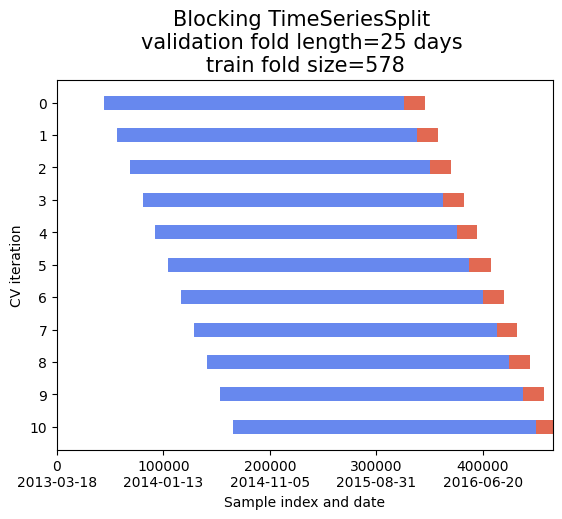

In [95]:
fig = plot_cv(tscv_blocking_chosen, 
              f'Blocking TimeSeriesSplit \nvalidation fold length={validation_set_size_chosen} days \ntrain fold size={days_in_best_train_length-1}',
              X_train, y_train, 
              scale_x=500)   
display(fig)

Check number of samples in the folds.

In [96]:

train_folds = [(train_sample_idxs[0], train_sample_idxs[-1], len(train_sample_idxs)) for train_sample_idxs, _ in tscv_blocking_chosen.split(X=X_train)]

print(f'{best_train_length=}')
print(f"Train folds' length:\n {'->'.join([f'[{fold[0]}--{fold[1]}({fold[2]})]' for fold in train_folds])}" )
for i, fold in enumerate(train_folds):
    if fold[2] != fold[1]-fold[0]+1:
        print(f'Caution {paint(f"fold {i} has wrong length", format)}: {fold[2]} != {fold[1]-fold[0]+1}')

best_train_length=280210
Train folds' length:
 [48649--329821(281173)]->[60690--342178(281489)]->[72740--354553(281814)]->[84790--366952(282163)]->[96846--379351(282506)]->[108921--391761(282841)]->[120996--404186(283191)]->[133071--416611(283541)]->[145167--429061(283895)]->[157288--441511(284224)]->[169423--453961(284539)]


### Make pipeline
Make pipeline with selected parameters, except for the train_length (it was used to make CV split). I do it to eliminate the wrapper WrapTrainSizeParam.

In [97]:
model_params = {p_name.split('__')[-1]: p_val 
                for p_name, p_val in grid_search_result_chosen['grid_search'].best_params_.items() 
                if 'randomforestclassifier' in p_name and 'train_length' not in p_name
               }
reducer_params = {p_name.split('__')[-1]: p_val 
                for p_name, p_val in grid_search_result_chosen['grid_search'].best_params_.items() 
                if 'reduce_dim' in p_name 
               }


In [98]:
model_chosen = Pipeline([   ('transformer', column_transformers_rf),
                            ('reduce_dim', FastICA(**reducer_params)),
                            ('classifier', RandomForestClassifier(**model_params))])
model_chosen

Pipeline(steps=[('transformer',
                 NamedTransformer(name='ordinal_std_quantile_power_kbins_q', transformer=EncoderNameScalerDigitCols(encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=555), transformers_columns=[(StandardScaler(), ['rsi', 'cmf']), (PowerTransformer(), ['Bollinger_width']), (KBinsDiscretizer(n_bins=10), ['Aroon_down', 'Aroo...ollinger_mavg', 'pvo', 'macd', 'dpo', 'kst_diff', 'adi', 'force_index', 'ease_of_movement', 'sma_ease_of_movement', 'volume_price_trend', 'nvi', 'day_return', 'cumulative_return'])], verbose_feature_names_out=False))),
                ('reduce_dim', FastICA(n_components=2)),
                ('classifier',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        min_samples_leaf=3,
                                        n_estimators=200))])

### Tune the threshold

In [99]:
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

rfc_tuned = TunedThresholdClassifierCV(
    model_chosen, cv = tscv_blocking_chosen, scoring="balanced_accuracy", store_cv_results=True, response_method="predict_proba"
).fit(X_train, y_train)
print(
    f"Cut-off point found at {rfc_tuned.best_threshold_:.3f}"
)
print(f'Best score: {rfc_tuned.best_score_}')
print(f'Best threshold: {rfc_tuned.best_threshold_}')

warnings.filterwarnings("default", category=UserWarning)


Cut-off point found at 0.513
Best score: 0.5220471969344768
Best threshold: 0.5128775708789751


### Scores on the train set

In [100]:
from sklearn.model_selection import FixedThresholdClassifier
model_fixed_tuned = FixedThresholdClassifier(model_chosen, threshold=rfc_tuned.best_threshold_)
model_fixed_thrhd = FixedThresholdClassifier(model_chosen, threshold=0.534)

In [101]:
shown_warnings = set()
def custom_warning_handler(ws):
    for w in ws:
        w_id = w.filename+':'+str(w.lineno)
        if w_id not in shown_warnings:
            shown_warnings.add(w_id)
            print(f"{w_id}: {w.category.__name__}: {w.message}")

In [102]:
class Cv_splitter(Protocol):
    def split(self, X): ...

def compare_scores_on_splits(model_tuples:tuple[str,BaseEstimator]|list[tuple[str,BaseEstimator]],
                             cv:Cv_splitter=tscv_blocking_chosen,
                             score_names:str|list[str]=['accuracy', 'roc_auc', 'f1'],
                             X:pd.DataFrame=X_train,
                             y:pd.Series=y_train):
    """
    Evaluates multiple machine learning models across different data splits using cross-validation.

    Parameters:
    ----------
    model_tuples : tuple or list of tuples
        A tuple or list of tuples where each tuple contains a model name (str) and the corresponding estimator (BaseEstimator).
    
    cv : Cv_splitter, optional
        Cross-validation splitter instance that defines the train-test split strategy (default is tscv_blocking_chosen).
    
    score_names : str or list of str, optional
        A string or list of strings specifying the evaluation metrics to compute (default: ['accuracy', 'roc_auc', 'f1']).
    
    X : pd.DataFrame, optional
        Feature dataset used for model evaluation (default: X_train).
    
    y : pd.Series, optional
        Target values corresponding to X (default: y_train).

    Returns:
    -------
    scores : pd.DataFrame
        A DataFrame containing model performance scores across splits.
        Columns are a MultiIndex of model names and score metrics, indexed by split number.

    Notes:
    ------
    - Models are fitted on the training indices provided by the cross-validation splitter.
    - Scores are calculated for each test split using a predefined scoring function.

    Example:
    --------
    >>> models = [('RandomForest', RandomForestClassifier()), ('LogisticRegression', LogisticRegression())]
    >>> cv = TimeSeriesSplit(n_splits=5)
    >>> compare_scores_on_splits(models, cv, ['accuracy', 'f1'], X_train, y_train)
    """
    if isinstance(score_names, str) :
        score_names = [score_names]

    if isinstance(model_tuples, tuple):
        model_tuples = [model_tuples]
    
    model_names = [model_tuple[0] if isinstance(model_tuple, tuple) else str(model_tuple) for model_tuple in model_tuples ]
    
    scores = pd.DataFrame(columns=pd.MultiIndex.from_product([model_names, score_names]), index=pd.Index(range(11), name='splits'))
    i = 0
    for tr_idx, ts_idx in cv.split(X):
        for model_name, model in model_tuples:
            with warnings.catch_warnings(record=True) as w:
                model.fit(X.iloc[tr_idx], y.iloc[tr_idx])
                custom_warning_handler(w)

            scores_model = scorer(model, X.iloc[ts_idx], y.iloc[ts_idx])
            for score_name in score_names:
                scores.loc[i, (model_name, score_name)] = scores_model[score_name]
        i += 1
    return scores

In [103]:
shown_warnings.clear()
scores_compare_tunned = compare_scores_on_splits(
    [('rf', model_chosen), ('rf_tuned', model_fixed_tuned), ('thrhd=.534', model_fixed_thrhd)],
    cv=tscv_blocking_chosen,
    score_names=['accuracy', 'roc_auc', 'f1'],
    X=X_train,
    y=y_train
)


c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.


In [104]:
print(scores_compare_tunned.rename(columns=lambda x: 'accur' if 'accur' in x else x, level=1).astype(float).round(3))
print('\n', paint('Mean:',format))
pd.DataFrame(scores_compare_tunned.mean()).T.astype(float).round(3)

           rf                rf_tuned                thrhd=.534               
        accur roc_auc     f1    accur roc_auc     f1      accur roc_auc     f1
splits                                                                        
0       0.479   0.561  0.622    0.528   0.560  0.580      0.553   0.560  0.229
1       0.454   0.528  0.607    0.483   0.527  0.573      0.539   0.527  0.356
2       0.561   0.534  0.658    0.465   0.534  0.383      0.390   0.534  0.016
3       0.532   0.524  0.670    0.501   0.526  0.366      0.460   0.525  0.006
4       0.519   0.522  0.683    0.523   0.524  0.549      0.479   0.522  0.035
5       0.534   0.560  0.689    0.544   0.561  0.557      0.470   0.561  0.029
6       0.556   0.549  0.713    0.515   0.548  0.428      0.451   0.547  0.051
7       0.486   0.489  0.653    0.494   0.490  0.489      0.510   0.488  0.054
8       0.515   0.546  0.679    0.539   0.546  0.588      0.489   0.544  0.041
9       0.522   0.502  0.677    0.499   0.500  0.515

rf                rf_tuned                thrhd=.534               
  accuracy roc_auc     f1 accuracy roc_auc     f1   accuracy roc_auc     f1
0    0.515   0.529  0.666    0.509   0.529  0.492      0.483   0.529  0.092

## 10 most important features

### 1. Feature Importance

To use RandomForest's property feature_importances_ we need to fit the model without the reducer, otherwise it shows only 'reduced' featuers (2 features).

In [105]:
first_train_fold_left = train_folds[0][0]
first_train_fold_right = train_folds[0][1]

In [106]:
first_train_fold_left, first_train_fold_right

(np.int64(48649), np.int64(329821))

In [107]:
model_chosen_no_reduce = Pipeline([   ('transformer', column_transformers_rf),
                            ('classifier', RandomForestClassifier(**model_params))])
model_chosen_no_reduce.fit(X_train[first_train_fold_left:first_train_fold_right+1], y_train[first_train_fold_left:first_train_fold_right+1])

c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and s

Pipeline(steps=[('transformer',
                 NamedTransformer(name='ordinal_std_quantile_power_kbins_q', transformer=EncoderNameScalerDigitCols(encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=555), transformers_columns=[(StandardScaler(), ['rsi', 'cmf']), (PowerTransformer(), ['Bollinger_width']), (KBinsDiscretizer(n_bins=10), ['Aroon_down', 'Aroo...ormer(output_distribution='normal'), ['Bollinger_mavg', 'pvo', 'macd', 'dpo', 'kst_diff', 'adi', 'force_index', 'ease_of_movement', 'sma_ease_of_movement', 'volume_price_trend', 'nvi', 'day_return', 'cumulative_return'])], verbose_feature_names_out=False))),
                ('classifier',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        min_samples_leaf=3,
                                        n_estimators=200))])

In [108]:
feature_importances_plot_file = os.path.join(results_dir,'feature_importances.png')
feature_importances = model_chosen_no_reduce.named_steps['classifier'].feature_importances_
features = column_transformers_rf.fit(X_train).get_feature_names_out()
# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
fig = plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.tight_layout()
plt.close()
fig.savefig(feature_importances_plot_file)
print('plot of feature importances are saved into ', paint(feature_importances_plot_file, format))


c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(


plot of feature importances are saved into  ../results/feature_importances.png


### 2. Partial Dependence Plots (PDP)
Partial dependence plots show the relationship between a feature and the predicted outcome, marginalizing over the values of all other features.

In [109]:
model_chosen.fit(X_train[first_train_fold_left:first_train_fold_right+1], y_train[first_train_fold_left:first_train_fold_right+1])

c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and s

Pipeline(steps=[('transformer',
                 NamedTransformer(name='ordinal_std_quantile_power_kbins_q', transformer=EncoderNameScalerDigitCols(encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=555), transformers_columns=[(StandardScaler(), ['rsi', 'cmf']), (PowerTransformer(), ['Bollinger_width']), (KBinsDiscretizer(n_bins=10), ['Aroon_down', 'Aroo...ollinger_mavg', 'pvo', 'macd', 'dpo', 'kst_diff', 'adi', 'force_index', 'ease_of_movement', 'sma_ease_of_movement', 'volume_price_trend', 'nvi', 'day_return', 'cumulative_return'])], verbose_feature_names_out=False))),
                ('reduce_dim', FastICA(n_components=2)),
                ('classifier',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        min_samples_leaf=3,
                                        n_estimators=200))])

In [110]:
from sklearn.inspection import PartialDependenceDisplay
partial_dependacy_file = os.path.join(results_dir, 'partial_dependacy.png')

top_features = importance_df['Feature'].head(20).tolist()
top_features_base=list(set([f if 'Aroon_' not in f else '_'.join(f.split('_')[:2]) for f in top_features]))
if not os.path.isfile(partial_dependacy_file):

    fig, ax = plt.subplots(figsize=(18, 18))
    PartialDependenceDisplay.from_estimator(model_chosen, X_train[first_train_fold_left:first_train_fold_right+1], features=top_features_base, grid_resolution=100, n_cols=4, ax=ax)#top_features[:16]
    plt.close(fig)
    fig.savefig(partial_dependacy_file)
    print('plot of partial dependacy saved into ', paint(partial_dependacy_file, format))
else:
    print('plot of partial dependacy already exists in ', paint(partial_dependacy_file, format))


plot of partial dependacy already exists in  ../results/partial_dependacy.png



### 3. SHAP Values

SHAP (SHapley Additive exPlanations) values provide a unified measure of feature importance and can explain individual predictions.


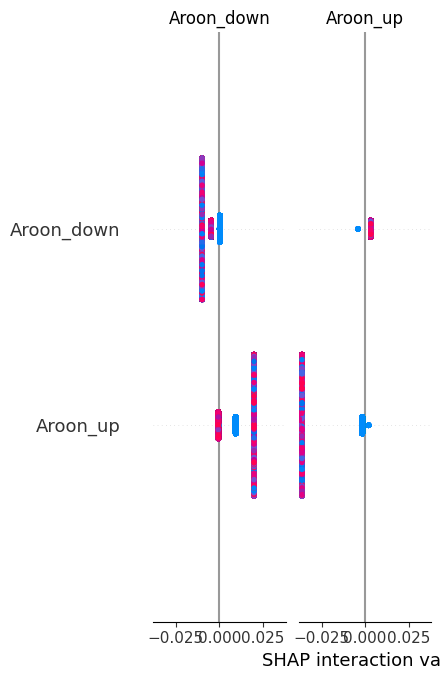

In [111]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model_chosen.named_steps['classifier'])
x_shap = X_train[X_train.columns.difference(['Name'])][first_train_fold_left:first_train_fold_right+1].astype(np.float64)
shap_values = explainer.shap_values(x_shap)

# Summary plot
shap.summary_plot(shap_values, x_shap, plot_type="bar")

In [112]:
# Detailed plot for a single prediction
# shap.initjs()
# shap.plots.force(explainer, shap_values[0,:], X_train.iloc[0,1:])

### 4. Pair Plot

A pair plot can help visualize the relationships between pairs of features and the target variable.

In [113]:
pair_plot_4_important_features_file = os.path.join(results_dir, 'pair_plot_4_important_features.png')
df_to_plot = X_train[top_features_base[:4]].copy()
df_to_plot['target'] = y_train
facet_grid = sns.pairplot(df_to_plot, hue='target')
plt.close()
facet_grid.figure.savefig(pair_plot_4_important_features_file)
print('plot of pair plot of 4 important features are saved into ', paint(pair_plot_4_important_features_file, format))


plot of pair plot of 4 important features are saved into  ../results/pair_plot_4_important_features.png


## Train model on the best features

### Create models

Create models, that use KBinsDiscretizer with 3 and 4 bins and models without transformers. The latter models will be used with the changed set. The changes are:
- transforme using the selected transformer
- extract only the best features. 

In [114]:
# create column transformer with KBinsDiscretizer with different number of bins (3 and 4)
kbins_quantile = KBinsDiscretizer(n_bins=10, strategy='quantile')
column_transformer_3 = NamedTransformer(name='target_std_quantile_power_kbins_q_3', 
                                      transformer=EncoderNameScalerDigitCols(
                                          transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                                (power_transforemer, power_transformer_cols), 
                                                                (KBinsDiscretizer(n_bins=3, strategy='quantile'), kbins_discretizer_cols), 
                                                                (quantile_transformer, quantile_transformer_cols)], 
                                          encoder=target_encoder, 
                                          verbose_feature_names_out=False
                                     )).set_output(transform='pandas')
column_transformer_4 = NamedTransformer(name='target_std_quantile_power_kbins_q_4', 
                                      transformer=EncoderNameScalerDigitCols(
                                          transformers_columns=[(std_scaler,standard_scaling_cols), 
                                                                (power_transforemer, power_transformer_cols), 
                                                                (KBinsDiscretizer(n_bins=4, strategy='quantile'), kbins_discretizer_cols), 
                                                                (quantile_transformer, quantile_transformer_cols)], 
                                          encoder=target_encoder, 
                                          verbose_feature_names_out=False
                                     )).set_output(transform='pandas')

# create models to test different strategies of using information of important features
model_3_bins = Pipeline([   ('transformer', column_transformer_3),
                            ('reduce_dim', FastICA(**reducer_params)),
                            ('classifier', RandomForestClassifier(**model_params))])
model_4_bins = Pipeline([   ('transformer', column_transformer_4),
                            ('reduce_dim', FastICA(**reducer_params)),
                            ('classifier', RandomForestClassifier(**model_params))])
model_reduced = Pipeline([  ('reduce_dim', FastICA(**reducer_params)),
                            ('classifier', RandomForestClassifier(**model_params))])
model_rfc = RandomForestClassifier(**model_params)

models_with_transformer = [('rf_3_bins', model_3_bins), 
                           ('rf_4_bins', model_4_bins)] 
models_no_transformer = [('rf_reduced', model_reduced), 
                         ('rf', model_rfc)]

### Fit the models

Fit models with transformers, that use less bins in KBinsDiscretizer (3 and 4 bins).

In [115]:

scores_with_transformer = compare_scores_on_splits(
    models_with_transformer,
    cv=tscv_blocking_chosen,
    score_names=['accuracy', 'roc_auc', 'f1'],
    X=X_train,
    y=y_train
)

In [116]:
print(scores_with_transformer)
print('\n', paint('Mean:',format))
print(scores_with_transformer.mean())

       rf_3_bins                     rf_4_bins                    
        accuracy   roc_auc        f1  accuracy   roc_auc        f1
splits                                                            
0       0.479323  0.559486  0.619335     0.479  0.558662  0.617378
1       0.463111  0.530944    0.6012  0.463677   0.53096  0.599819
2       0.552948  0.525416  0.656716  0.556335  0.525532  0.664389
3       0.529559  0.523546  0.649058  0.531414  0.524674  0.658837
4       0.521112  0.515663  0.674659   0.52087  0.515905  0.674442
5        0.53666  0.553033  0.695767  0.536097  0.553869  0.693763
6       0.552354  0.548982  0.707356  0.552274  0.546664  0.707841
7       0.484418  0.488517  0.646706  0.484177   0.48805  0.646054
8       0.514137  0.545326  0.674172  0.513574  0.545255  0.675351
9       0.526024  0.497075  0.684287  0.526747  0.497947  0.684211
10      0.513253  0.506443  0.673843  0.514458  0.507639  0.673473

 Mean:
rf_3_bins  accuracy    0.515718
           roc_auc    

Fit 2 models - with and without the demention reducer - on the set that comprises only the best features.

In [117]:
scores_no_transformer = compare_scores_on_splits(
    models_no_transformer,
    cv=tscv_blocking_chosen,
    score_names=['accuracy', 'roc_auc', 'f1'],
    X=column_transformers_rf.fit_transform(X_train)[top_features],
    y=y_train
)


c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [118]:
print(scores_no_transformer)
print('\n', paint('Mean:',format))
print(scores_no_transformer.mean())

       rf_reduced                            rf                    
         accuracy   roc_auc        f1  accuracy   roc_auc        f1
splits                                                             
0        0.471474  0.543932  0.626052  0.475682   0.55002  0.625166
1         0.45996  0.513209  0.600514  0.476202  0.537893  0.603208
2         0.53093  0.530558  0.605588  0.505041  0.515139  0.539783
3         0.53093  0.515012  0.645323  0.527946   0.51141  0.654874
4        0.519742  0.518384  0.683987  0.514182  0.515528   0.64966
5        0.535131  0.564442  0.696989  0.540121  0.565252  0.661533
6        0.556378  0.544379  0.712197  0.533441  0.510925  0.664971
7        0.485622  0.485824  0.646773  0.481606   0.47682  0.621644
8        0.514137  0.544123  0.675431  0.521285  0.540346  0.652923
9        0.525542  0.499102  0.671852  0.512209  0.486397  0.618841
10       0.512932  0.507965  0.675514  0.522892   0.52414  0.643415

 Mean:
rf_reduced  accuracy     0.51298
       

### Compare the scores

In [119]:
df1 = scores_with_transformer.melt(value_name='score values', ignore_index=False).reset_index().rename(columns={'variable_0':'model', 'variable_1':'score'})
df2 = scores_no_transformer.melt(value_name='score values', ignore_index=False).reset_index().rename(columns={'variable_0':'model', 'variable_1':'score'})
df2[32:35]

,splits,model,score,score values
32,10,rf_reduced,f1,0.675514
33,0,rf,accuracy,0.475682
34,1,rf,accuracy,0.476202


In [120]:
data_to_plot = pd.concat([df1, df2], axis=0, ignore_index=True)
data_to_plot[64:67]

,splits,model,score,score values
64,9,rf_4_bins,f1,0.684211
65,10,rf_4_bins,f1,0.673473
66,0,rf_reduced,accuracy,0.471474


<Axes: title={'center': 'Compare models with and without transformer on splits'}, xlabel='splits', ylabel='score values'>

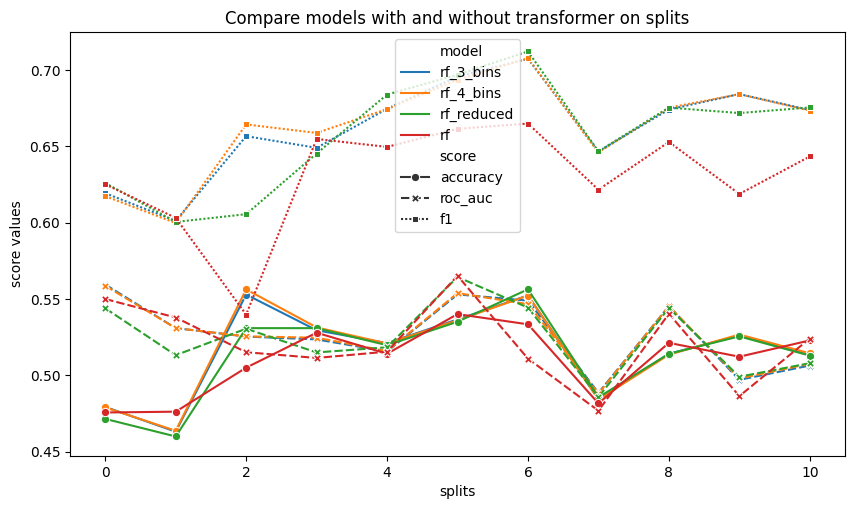

In [121]:
fig = plt.figure(figsize=(10, 5.5))
plt.title('Compare models with and without transformer on splits')
sns.lineplot(data=data_to_plot, x='splits', y='score values', style='score', hue='model', markers=True, dashes=True, legend='brief')

Models with fewer bins look a bit better than the models which are trained only on the top features. Reducers help more than cutting off the number of bins. 

### Create and fit the 'mix' model

Create a model with 5 bins to use on the set that comprises only the best features, it let train the model on the best features and use all Aroon values, not only "the best" bins. 

Create a transformer for the model.

In [122]:
def intercept_with_top_feature_base(lst:list) -> list:
    return list(set(lst) & set(top_features_base))

In [123]:
column_transformer_5_best_features = NamedTransformer(name='target_std_quantile_power_kbins_q_5_best_features', 
                                      transformer=EncoderNameScalerDigitCols(
                                          transformers_columns=[(std_scaler,intercept_with_top_feature_base(standard_scaling_cols)), 
                                                                (power_transforemer, intercept_with_top_feature_base(power_transformer_cols)), 
                                                                (KBinsDiscretizer(n_bins=5, strategy='quantile'), intercept_with_top_feature_base(kbins_discretizer_cols)), 
                                                                (quantile_transformer, intercept_with_top_feature_base(quantile_transformer_cols))], 
                                          encoder=target_encoder, 
                                          verbose_feature_names_out=False
                                     )).set_output(transform='pandas')

Build and fit the Pipeline.

In [124]:

model_best_features = Pipeline([('transformer', column_transformer_5_best_features),
                                ('reduce_dim', FastICA(**reducer_params)),
                                ('classifier', RandomForestClassifier(**model_params))])

scores_with_transformer_best_features = compare_scores_on_splits(
    ('rf_5_bins_best', model_best_features),
    cv=tscv_blocking_chosen,
    score_names=['accuracy', 'roc_auc', 'f1'],
    X=X_train[list(top_features_base)+['Name']],
    y=y_train
)

In [125]:
print(scores_with_transformer_best_features)
print('\n', paint('Mean:',format))
print(scores_with_transformer_best_features.mean())

       rf_5_bins_best                    
             accuracy   roc_auc        f1
splits                                   
0            0.471555  0.550405  0.626985
1            0.460606  0.524237  0.603222
2            0.554803  0.528207  0.658247
3            0.523833  0.519197  0.617765
4            0.519903  0.517144  0.676301
5            0.535131  0.555927  0.690129
6            0.554205  0.546317  0.706201
7            0.484739  0.487509  0.647469
8            0.514458  0.545868  0.677514
9            0.524498  0.496259  0.679376
10           0.511727  0.505032   0.67646

 Mean:
rf_5_bins_best  accuracy    0.514132
                roc_auc       0.5251
                f1           0.65997
dtype: object


### Compare the scores of *3-bins* models to the Selected Model

<Axes: title={'center': 'Compare models with different number of bins and with best features on splits'}, xlabel='splits', ylabel='score values'>

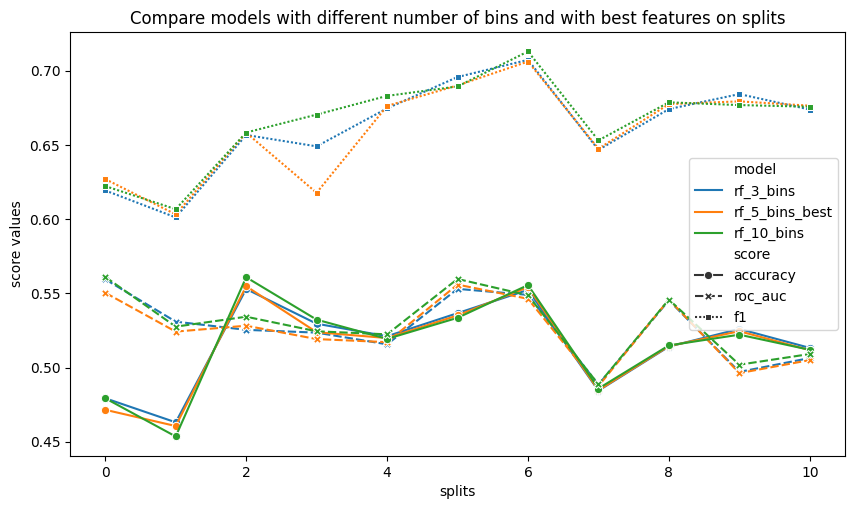

In [126]:
df1 = scores_with_transformer.loc[:,('rf_3_bins', slice(None))].melt(value_name='score values', ignore_index=False).reset_index().rename(columns={'variable_0':'model', 'variable_1':'score'})
df2 = scores_with_transformer_best_features.melt(value_name='score values', ignore_index=False).reset_index().rename(columns={'variable_0':'model', 'variable_1':'score'})
df3 = scores_compare_tunned.loc[:,('rf', slice(None))].melt(value_name='score values', ignore_index=False).reset_index().rename(columns={'variable_0':'model', 'variable_1':'score'})
df3['model'] = 'rf_10_bins'
data_to_plot = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

fig = plt.figure(figsize=(10, 5.5))
plt.title('Compare models with different number of bins and with best features on splits')
sns.lineplot(data=data_to_plot, x='splits', y='score values', style='score', hue='model', markers=True, dashes=True, legend='brief')

Reducers help more than cutting off the number of bins. 

### GridSearch a model with different transformers.

Choose parameters to train on.

In [127]:
top_transform = grid_search_results_t_r[2]['scores_by_transformers']['test'].sort_values(ascending=False).head(10)
top_transform

drop_standard_robust                  0.524476
ordinal_quantile_power                0.524393
ordinal_standard_not_indicators       0.523414
target_robust_not_indicators          0.523196
target_quantile_power_kbins_u         0.522563
ordinal_std_quantile_power_kbins_u    0.522445
ordinal_quantile_power_kbins_u        0.522079
ordinal_max_abs_not_indicators        0.521552
drop_standard                         0.521526
drop_robust_not_indicators            0.521510
Name: test, dtype: float64

In [128]:
column_transformer_target_5u = NamedTransformer(name='target_quantile_power_kbins_u_5', 
                                            transformer=EncoderNameScalerDigitCols(
                                                transformers_columns=[(power_transforemer, power_transformer_cols), 
                                                                      (KBinsDiscretizer(n_bins=5, strategy='uniform'), kbins_discretizer_cols), 
                                                                      (quantile_transformer,standard_scaling_cols+quantile_transformer_cols)], 
                                                encoder=target_encoder, verbose_feature_names_out=False
                                                )).set_output(transform='pandas')


In [129]:
configer_classifier_rf_t_r=[
    {
        'model':RandomForestClassifier, 
        'params': {
            'n_estimators':[model_params['n_estimators']],
            #'min_samples_split': [2], 2- default 
            'min_samples_leaf': [model_params['min_samples_leaf']], 
            'max_features': [model_params['max_features']],
            'max_depth': [3, 4, 5],
        }
    },
]
column_transformers_rf_t_r = [column_transformers['ordinal_quantile_power'],
                              column_transformers['target_robust_not_indicators'],
                              column_transformers['target_quantile_power_kbins_u']]

dim_reducers_rf_t_r =[{'model': FastICA(), 'params': {'n_components': [2, 4, 10, 20]}}, 
                      {'model': PCA(), 'params': {'n_components': [2, 4, 10, 20]}},
                      {'model': 'passthrough', 'params':{}}]


GridSearch

In [130]:
results_file_rf_t_r= os.path.join(pkl_dir,'gridsearch_results_rf_t_r.pkl' )
grid_search_results_rf_t_r = train_classifiers(results_file=results_file_rf_t_r,
                                         classifiers=configer_classifier_rf_t_r,
                                         column_transformers=column_transformers_rf_t_r,
                                         configed_dim_reducers=dim_reducers_rf_t_r,
                                         train_set_lengths=None, 
                                         X=X_train_small, y=y_train_small, 
                                         scoring=scorer, 
                                         cv=tscv_blocking_chosen,
)

load trained models from ../results/pickled\gridsearch_results_rf_t_r.pkl
Model randomforestclassifier:
With parameters: [{'randomforestclassifier__n_estimators': [200], 'randomforestclassifier__min_samples_leaf': [3], 'randomforestclassifier__max_features': [None], 'randomforestclassifier__max_depth': [3, 4, 5], 'transformer': [ordinal_quantile_power, target_robust_not_indicators, target_quantile_power_kbins_u], 'reduce_dim': [FastICA()], 'reduce_dim__n_components': [2, 4, 10, 20]}, {'randomforestclassifier__n_estimators': [200], 'randomforestclassifier__min_samples_leaf': [3], 'randomforestclassifier__max_features': [None], 'randomforestclassifier__max_depth': [3, 4, 5], 'transformer': [ordinal_quantile_power, target_robust_not_indicators, target_quantile_power_kbins_u], 'reduce_dim': [PCA()], 'reduce_dim__n_components': [2, 4, 10, 20]}, {'randomforestclassifier__n_estimators': [200], 'randomforestclassifier__min_samples_leaf': [3], 'randomforestclassifier__max_features': [None], 'ra

In [131]:
hyperparameters_file_best= os.path.join(pkl_dir, 'selected_model.txt')
with open(hyperparameters_file_best, 'w', encoding='utf-8') as f:
    for grid_search_result in grid_search_results_rf_t_r:
        f.write(f"{grid_search_result['name']}:\n")
        f.write(f"Best parameters: {grid_search_result['grid_search'].best_params_}\n")
        f.write(f"Best score: {grid_search_result['grid_search'].best_score_}\n")
        f.write(f"Grid serach time: {grid_search_result['search_time']/60} minutes")

### Analyze results

In [132]:
save_grid_search_key_results(grid_search_results_rf_t_r, "Choose RandomForestClassifier's hyperparameters after feature analysis")
save_scores_of_stage_to_file(grid_search_results_rf_t_r, "Choose RandomForestClassifier's hyperparameters after feature analysis")

--- data is saved to ../results/key_results.md ---
randomforestclassifier
Saving randomforestclassifier
({'randomforestcl...
--- data is saved to ../results/ml_metrics_train.md ---


In [133]:
with open(accuracy_roc_file, 'a', encoding='utf-8') as f: 
    f.write("## Choose RandomForestClassifier's hyperparameters  after feature analysis\n")
accuracy_dfs = {}
roc_auc_dfs = {}
split7_9 = {}
top_scores = {}
for grid_search_result in grid_search_results_rf_t_r:
    name_ = grid_search_result['name']
    sets = grid_search_result['scores_on_splits'].index.get_level_values('set')
    accuracy_dfs[name_] = grid_search_result['scores_on_splits']['accuracy'][sets=='test'].dropna(how='all') 
    roc_auc_dfs[name_] = grid_search_result['scores_on_splits']['roc_auc'][sets=='test'].dropna(how='all')
    splits = grid_search_result['scores_on_splits'].index.get_level_values('split')
    split7_9[name_] = grid_search_result['scores_on_splits'][['accuracy','roc_auc']][(splits=='split7')|(splits=='split9')].dropna(how='all')
    top_scores[name_] = pd.concat([accuracy_dfs[name_].nlargest(5,keep='all'),roc_auc_dfs[name_].nlargest(5,keep='all')], axis='columns')
    top_scores[name_] = pd.concat([top_scores[name_],split7_9[name_]], axis='index')

add_data_frames_to_file(accuracy_roc_file, top_scores)

Saving randomforestclassifier...
--- data is saved to ../results/ml_metrics_train_accuracy_roc.md ---


In [134]:
comparation_table = create_comparation_table([grid_search_results_rf, grid_search_results_rf_t_r],
                          ['RFC', 'RFC_trsf_redc'],
                          ['randomforestclassifier',], 
                          ['score', ])
comparation_table#[comparation_table['diff'] != 'Same']

RFC  \
model                  param                                             
randomforestclassifier max_depth_best                                3   
                       max_depth_grid                        [3, 4, 5]   
                       max_features_best                          None   
                       max_features_grid                        [None]   
                       min_samples_leaf_best                         3   
                       min_samples_leaf_grid                 [3, 5, 6]   
                       n_estimators_best                           200   
                       n_estimators_grid               [200, 250, 300]   
                       score                                  0.530081   
                       train_length_best                        280210   
                       train_length_grid      [265602, 280210, 300462]   

                                             RFC_trsf_redc       diff  
model                  param                                           
randomforestclassifier max_depth_best                    5         --  
                       max_depth_grid            [3, 4, 5]       Same  
                       max_features_best              None       Same  
                       max_features_grid            [None]       Same  
                       min_samples_leaf_best             3       Same  
                       min_samples_leaf_grid           [3]         --  
                       n_estimators_best               200       Same  
                       n_estimators_grid             [200]         --  
                       score                      0.514544  Best: RFC  
                       train_length_best               NaN         --  
                       train_length_grid               NaN         --

In [135]:
training_params = ['max_depth', 'transformer', 'reduce_dim', 'reduce_dim__n_components']
comparations, best_params  = create_train_test_comparation_tables(grid_search_results_rf_t_r, training_params)
titles = [f'Best {param_name}: {best_value}' for param_name, best_value in best_params.items()]
display_df_side_by_side(comparations.values(), titles)

,score,train,test,Model name
3,roc_auc,0.546388,0.509980,randomforestclassifier
4,roc_auc,0.568592,0.509557,randomforestclassifier
5,roc_auc,0.594870,0.514544,randomforestclassifier
3,accuracy,0.522645,0.509182,randomforestclassifier
4,accuracy,0.533147,0.507091,randomforestclassifier
5,accuracy,0.543080,0.514273,randomforestclassifier
,score,train,test,Model name
ordinal_quantile_power,roc_auc,0.577693,0.494258,randomforestclassifier
target_robust_not_indicators,roc_auc,0.594870,0.514544,randomforestclassifier
target_quantile_power_kbins_u,roc_auc,0.589237,0.505674,randomforestclassifier


In [136]:
comparations['max_depth'].index = comparations['max_depth'].index.astype(str)

In [137]:
param_name = 'reducers'
training_params = ['reduce_dim', 'reduce_dim__n_components']
param_comparation, best_param = create_tables_of_scores_by_param(grid_search_results_rf_t_r, par_names=training_params, key=f'rocauc_by_{param_name}')
param_comparation_accuracy, _ = create_tables_of_scores_by_param(grid_search_results_rf_t_r, par_names=training_params, score='accuracy', key=f'accuracy_by_{param_name}')
param_comparation = pd.concat([param_comparation, param_comparation_accuracy], axis=0, keys=['roc_auc', 'accuracy']).reset_index(names=['score', *training_params]) 
param_comparation[param_name] = param_comparation['reduce_dim'].astype(str) + '_' + param_comparation['reduce_dim__n_components'].astype(str).str.split(' ').str[-1]
comparations[param_name] = param_comparation.set_index(param_name)
best_params[param_name] = best_param
comparations[param_name]

,score,reduce_dim,reduce_dim__n_components,train,test,Model name
reducers,,,,,,
FastICA()_2,roc_auc,FastICA(),2,0.59487,0.514544,randomforestclassifier
FastICA()_4,roc_auc,FastICA(),4,0.607427,0.503872,randomforestclassifier
FastICA()_10,roc_auc,FastICA(),10,0.614427,0.499082,randomforestclassifier
FastICA()_20,roc_auc,FastICA(),20,0.643996,0.507843,randomforestclassifier
PCA()_2,roc_auc,PCA(),2,0.591382,0.506457,randomforestclassifier
PCA()_4,roc_auc,PCA(),4,0.603817,0.503539,randomforestclassifier
PCA()_10,roc_auc,PCA(),10,0.613755,0.498633,randomforestclassifier
PCA()_20,roc_auc,PCA(),20,0.636306,0.503695,randomforestclassifier
passthrough_-,roc_auc,passthrough,-,0.626149,0.508372,randomforestclassifier


In [138]:
rocauc_by_splits_rf_t_r_file = os.path.join(results_dir,'roc_auc_rf_t_r.pdf')
# plot by splits
data_to_plot = grid_search_results_rf_t_r[0]['best_estimator_scores'].reset_index().melt(id_vars=['split', 'set'], value_vars=['roc_auc', 'accuracy'], var_name='score_kind', value_name='score')
snsplot_split = lineplot(data_to_plot, x='split',  y='score', style='set', hue='score_kind', title='Compare ROC_AUC of the best models', figsize=(11, 4)) 

snsplots = []
for param_name, comparation in comparations.items():   
    df_to_plot = comparation.reset_index(names=param_name)
    snsplots.append(plot_validation_by(df_to_plot, by=param_name, score_to_plot='ROC_AUC and accuracy', hue='score') )
with PdfPages(rocauc_by_splits_rf_t_r_file) as pdf:
    snsplot_split.figure.savefig(pdf, format='pdf')
    for snsplot in snsplots:
        snsplot.figure.savefig(pdf, format='pdf')
print('plot of ROC_AUC scores are saved into ', paint(rocauc_by_splits_rf_t_r_file, format))

plot of ROC_AUC scores are saved into  ../results/roc_auc_rf_t_r.pdf


# Strategy backtesting

## Predict

### Create set of data

In [139]:
train_prediction_X = pd.concat([X_train, X_test])
train_prediction_y = pd.concat([y_train, y_test])
train_prediction_return = pd.concat([X_train_return, X_test_return])

### Train loop

In [140]:
predictions_proba = []
predictions_fixed_proba = []
predictions_tuned_proba = []
predictions = []
predictions_fixed = []
predictions_tuned = []

for train_index, test_index in tscv_blocking_chosen.split(train_prediction_X):
    X_train_fold, X_val_fold = train_prediction_X.iloc[train_index], train_prediction_X.iloc[test_index]
    y_train_fold, y_val_fold = train_prediction_y.iloc[train_index], train_prediction_y.iloc[test_index]
    model_chosen.fit(X_train_fold, y_train_fold)
    model_fixed_thrhd.fit(X_train_fold, y_train_fold)
    model_fixed_tuned.fit(X_train_fold, y_train_fold)
    
    preds_proba = model_chosen.predict_proba(X_val_fold)
    predictions_proba.append(pd.Series(preds_proba[:, 1], index=X_val_fold.index))
    preds = model_chosen.predict(X_val_fold)
    predictions.append(pd.Series(preds, index=X_val_fold.index))

    preds_proba = model_fixed_thrhd.predict_proba(X_val_fold)
    predictions_fixed_proba.append(pd.Series(preds_proba[:, 1], index=X_val_fold.index))
    preds = model_fixed_thrhd.predict(X_val_fold)
    predictions_fixed.append(pd.Series(preds, index=X_val_fold.index))

    preds_proba = model_fixed_tuned.predict_proba(X_val_fold)
    predictions_tuned_proba.append(pd.Series(preds_proba[:, 1], index=X_val_fold.index))
    preds = model_fixed_tuned.predict(X_val_fold)
    predictions_tuned.append(pd.Series(preds, index=X_val_fold.index))

predicted_probabilities = pd.concat(predictions_proba)
predicted_probabilities_fixed = pd.concat(predictions_fixed_proba)
predicted_probabilities_tuned = pd.concat(predictions_tuned_proba)
predicted = pd.concat(predictions)
predicted_fixed = pd.concat(predictions_fixed)
predicted_tuned = pd.concat(predictions_tuned)

c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\alena\AI\SP500-strategies\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users

In [141]:
print('accuracy model',accuracy_score(y_test, predicted))
print('accuracy fixed threshold model',accuracy_score(y_test, predicted_fixed))
print('accuracy tuned threshold model',accuracy_score(y_test, predicted_tuned))

accuracy model 0.5260259280998862
accuracy fixed threshold model 0.4747277114719885
accuracy tuned threshold model 0.5030109350203266


In [142]:
probabilities = pd.concat([y_train, predicted_probabilities])

## Create strategies

### Generate signal

In [143]:
def long_only_strategy(df_returns, probabilities, threshold=0.5, proportional=False):
    res = df_returns.copy()
    res['Probabilities'] = probabilities
    res['Signal'] = res['Probabilities'].apply(lambda x: 1 if x > threshold else 0)
    # if there is no invest on all stock on a day, invest $1 on the best stock
    def _best_stock(x):
        return (x['return'] == x['return'].max()).astype(int)
    res['Signal'] = res.groupby('date').apply(lambda df: _best_stock(df) if df['Signal'].sum()==0 else df['Signal']).reset_index(level=0, drop=True)
    if proportional:
        res['Signal'] = res['Probabilities'].where(res['Signal'].astype(bool), 0)
    res['Signal'] = res['Signal'].groupby('date').transform(lambda x: x/x.sum())
    res['Strategy_Return'] = res['Signal'] * res['return']
    return res

long_only_df = long_only_strategy(train_prediction_return, probabilities, 0.5)
long_only_prop_df = long_only_strategy(train_prediction_return, probabilities, 0.5, proportional=True)

In [144]:
def short_only_strategy(df_returns, probabilities, threshold=0.5, proportional=False):
    res = df_returns.copy()
    res['Probabilities'] = probabilities
    res['Signal'] = res['Probabilities'].apply(lambda x: 1 if x < threshold else 0)
    # if there is no invest on all stock on a day, invest $1 on the best stock
    def _worst_stock(x):
        return (x['return'] == x['return'].min()).astype(int)
    res['Signal'] = res.groupby('date').apply(lambda df: _worst_stock(df) if df['Signal'].sum()==0 else df['Signal']).reset_index(level=0, drop=True)
    if proportional:
        res['Signal'] = (1-res['Probabilities']).where(res['Signal'].astype(bool), 0)
    res['Signal'] = res['Signal'].groupby('date').transform(lambda x: x/x.sum())
    res['Strategy_Return'] = - res['Signal'] * res['return']
    return res

short_only_df = short_only_strategy(train_prediction_return, probabilities, 0.5)
short_only_prop_df = short_only_strategy(train_prediction_return, probabilities, 0.5, proportional=True)

In [145]:
def long_short_strategy(df_returns, probabilities, thresholds=0.5):
    res = df_returns.copy()
    res['Probabilities'] = probabilities
    if isinstance(thresholds, Iterable):
        res['Signal'] = res['Probabilities'].apply(lambda x: -1 if x < thresholds[0] else (1 if x > thresholds[1] else 0))
    else:
        res['Signal'] = res['Probabilities'].apply(lambda x: -1 if x < thresholds else 1)
    # if there is no invest on all stock on a day, invest $1 on the best stock
    def _stocks_on_edge(x):
        return -(x['return'] == x['return'].min()).astype(int) + (x['return'] == x['return'].max()).astype(int)
    res['Signal'] = res.groupby('date').apply(lambda df: _stocks_on_edge(df) if df['Signal'].abs().sum()==0 else df['Signal']).reset_index(level=0, drop=True)
    res['Signal'] = res['Signal'].groupby('date').transform(lambda x: x/x.abs().sum())
    res['Strategy_Return'] = res['Signal'] * res['return']
    return res

long_short_df = long_short_strategy(train_prediction_return, probabilities, 0.5)
long_short_2_thresholds_df = long_short_strategy(train_prediction_return, probabilities, [0.4, 0.6])

### Compare strategies' PnL

In [146]:
PnL = pd.DataFrame({'Long Only': long_only_df.groupby('date')['Strategy_Return'].sum(), 
                    'Long Only proportional': long_only_prop_df.groupby('date')['Strategy_Return'].sum(), 
                    'Short Only': short_only_df.groupby('date')['Strategy_Return'].sum(), 
                    'Short Only proportional': short_only_prop_df.groupby('date')['Strategy_Return'].sum(),
                    'Long Short': long_short_df.groupby('date')['Strategy_Return'].sum(),
                    'Long Short 2 thresholds': long_short_2_thresholds_df.groupby('date')['Strategy_Return'].sum(),
                    })
PnL['SP500'] = sp500_history.loc[PnL.index,'return']
for col in PnL.columns:
    PnL[f'{col} cumulative'] = PnL[col].cumsum()
PnL

,Long Only,Long Only proportional,Short Only,Short Only proportional,Long Short,Long Short 2 thresholds,SP500,Long Only cumulative,Long Only proportional cumulative,Short Only cumulative,Short Only proportional cumulative,Long Short cumulative,Long Short 2 thresholds cumulative,SP500 cumulative
date,,,,,,,,,,,,,,
2013-03-18,0.011550,0.011550,0.007115,0.007115,0.010926,0.010926,0.006697,0.011550,0.011550,0.007115,0.007115,0.010926,0.010926,0.006697
2013-03-19,0.005723,0.005723,0.011291,0.011291,0.010577,0.010577,-0.008282,0.017273,0.017273,0.018406,0.018406,0.021503,0.021503,-0.001585
2013-03-20,0.009188,0.009188,0.006056,0.006056,0.008458,0.008458,0.007174,0.026461,0.026461,0.024462,0.024462,0.029960,0.029960,0.005589
2013-03-21,0.005812,0.005812,0.007210,0.007210,0.006793,0.006793,-0.003340,0.032273,0.032273,0.031672,0.031672,0.036753,0.036753,0.002249
2013-03-22,0.010215,0.010215,0.004393,0.004393,0.009273,0.009273,0.007785,0.042488,0.042488,0.036065,0.036065,0.046027,0.046027,0.010034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-30,-0.002467,-0.002522,0.081106,0.081106,-0.002467,0.121158,-0.000648,9.854025,9.853413,23.432676,23.432336,10.706142,33.706220,0.620781
2018-01-31,-0.020129,-0.020127,0.076093,0.076093,-0.020129,0.077537,-0.021209,9.833895,9.833285,23.508769,23.508428,10.686013,33.783757,0.599572
2018-02-01,-0.036907,-0.036877,0.092243,0.092243,-0.036907,0.064608,-0.040979,9.796988,9.796408,23.601012,23.600671,10.649106,33.848365,0.558593


PnL for the test period

In [147]:
PnL[PnL.index>=X_test.index[0]]

,Long Only,Long Only proportional,Short Only,Short Only proportional,Long Short,Long Short 2 thresholds,SP500,Long Only cumulative,Long Only proportional cumulative,Short Only cumulative,Short Only proportional cumulative,Long Short cumulative,Long Short 2 thresholds cumulative,SP500 cumulative
date,,,,,,,,,,,,,,
2017-01-03,-0.003180,-0.003264,0.004196,0.004196,-0.003165,0.142602,-0.000771,9.664372,9.664289,9.288436,9.288436,10.516792,10.662559,0.400066
2017-01-04,0.003091,0.003091,0.058385,0.058385,0.003091,0.057461,0.003517,9.667464,9.667380,9.346821,9.346821,10.519883,10.720021,0.403583
2017-01-05,-0.005469,-0.005484,0.000525,0.000691,-0.005445,0.120593,-0.003549,9.661995,9.661896,9.347346,9.347511,10.514438,10.840614,0.400035
2017-01-06,0.001560,0.001602,-0.002358,-0.002553,0.001544,0.136727,0.000000,9.663554,9.663498,9.344988,9.344958,10.515982,10.977340,0.400035
2017-01-09,0.002794,0.002805,0.004267,0.004267,0.002797,0.056793,0.002830,9.666349,9.666303,9.349255,9.349226,10.518780,11.034133,0.402864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-30,-0.002467,-0.002522,0.081106,0.081106,-0.002467,0.121158,-0.000648,9.854025,9.853413,23.432676,23.432336,10.706142,33.706220,0.620781
2018-01-31,-0.020129,-0.020127,0.076093,0.076093,-0.020129,0.077537,-0.021209,9.833895,9.833285,23.508769,23.508428,10.686013,33.783757,0.599572
2018-02-01,-0.036907,-0.036877,0.092243,0.092243,-0.036907,0.064608,-0.040979,9.796988,9.796408,23.601012,23.600671,10.649106,33.848365,0.558593


In [148]:
def _get_fig_and_axes(ncols, n_axes, row_high=4, fig_width=12):
    nrows = math.ceil(n_axes / ncols)
    fig, axs = plt.subplots(nrows, ncols, figsize=(fig_width, nrows * row_high))
    axs = axs.flatten()
    return fig, axs

In [149]:
last_train_date = X_train_return.index.max()
pnl_plot_file = os.path.join(results_dir, 'strategies_test_period.png')
cols_to_plot = [col for col in PnL.columns if 'cumulative' not in col and 'SP500' not in col]
data_to_plot = PnL[PnL.index>=X_test.index[0]].reset_index()#.melt(id_vars='date', value_vars=cols_to_plot, var_name='Strategy', value_name='Return')

title = 'Profit and Loss of the strategies by days'
fig, axs = _get_fig_and_axes(1, len(cols_to_plot), fig_width=15)
fig.suptitle(title)
for i, col in enumerate(cols_to_plot):
    sns.lineplot(data=data_to_plot, x='date', y=col,  markers=True, dashes=True, legend='brief', ax=axs[i], label=col)
    sns.lineplot(data=data_to_plot, x='date', y='SP500', markers=True, dashes=True, legend='brief', ax=axs[i], label='SP500')
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.close(fig)
fig.savefig(pnl_plot_file)
print(f'Profit and Loss plot saved to {paint(pnl_plot_file, format)}')

Profit and Loss plot saved to ../results/strategies_test_period.png


In [150]:
last_train_date = X_train_return.index.max()
pnl_plot_file = os.path.join(results_dir, 'strategies.png')
cols_to_plot = [col for col in PnL.columns if 'cumulative' not in col]
data_to_plot = PnL.reset_index().melt(id_vars='date', value_vars=cols_to_plot, var_name='Strategy', value_name='Return')

#snsplot = lineplot(data_to_plot, 'date', title='Profit and Loss of the strategies by days', score_to_plot='Return',style=None, hue='Strategy', figsize=(10, 6))
figsize = (10, 6)
title = 'Profit and Loss of the strategies by days'
plt.figure(figsize=figsize)
plt.title(title)
snsplot = sns.lineplot(data=data_to_plot, x='date', y='Return', style=None, hue='Strategy', markers=True, dashes=True, legend='brief')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
snsplot.plot([last_train_date, last_train_date], [PnL[cols_to_plot].min().min(), PnL[cols_to_plot].max().max()], 'r--')
snsplot.figure.tight_layout()
plt.close(snsplot.figure)
snsplot.figure.savefig(pnl_plot_file)
print(f'Profit and Loss plot saved to {paint(pnl_plot_file, format)}')

Profit and Loss plot saved to ../results/strategies.png


In [151]:
pnl_cumulative_plot_file = os.path.join(results_dir, 'strategies_cumulative_plot.png')
cols_to_plot = [col for col in PnL.columns if 'cumulative' in col]
data_to_plot = PnL.reset_index().melt(id_vars='date', value_vars=cols_to_plot, var_name='Strategy', value_name='Cumulative Return')

#snsplot = lineplot(data_to_plot, 'date', title='Cumulative Profit and Loss of the strategies by days', score_to_plot='Cumulative Return',style=None, hue='Strategy', figsize=(10, 6))
figsize = (10, 6)
title = 'Cumulative Profit and Loss of the strategies by days'
plt.figure(figsize=figsize)
plt.title(title)
snsplot = sns.lineplot(data=data_to_plot, x='date', y='Cumulative Return', style=None, hue='Strategy', markers=True, dashes=True, legend='brief')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
snsplot.plot([last_train_date, last_train_date], [PnL[cols_to_plot].min().min(), PnL[cols_to_plot].max().max()], 'r--')
plt.close(snsplot.figure)
snsplot.figure.savefig(pnl_cumulative_plot_file)
print(f'Cumulative Profit and Loss plot saved to {paint(pnl_cumulative_plot_file, format)}')

Cumulative Profit and Loss plot saved to ../results/strategies_cumulative_plot.png


In [152]:
cum_cols = [col for col in PnL.columns if 'cumulative' in col]
cummax = PnL[cum_cols].cummax()
drawdown = (cummax - PnL[cum_cols])*100/cummax #(PnL[cum_cols]-cummax)*100/cummax
max_drawdown = drawdown.min()

In [153]:
report_file = os.path.join(results_dir, 'report.md')
with open(report_file, 'w') as f:
    f.write(f'# Report\n')
    f.write(f'\n\n## Features used\n\n')
    f.write(pd.Series(X_train.columns).to_markdown())
    f.write(f'\n\n## Pipeline used\n\n')
    f.write(model_chosen.named_steps.__repr__())
    f.write(f'\n\nwith parameters\n\n')
    f.write(pd.Series(model_chosen.get_params()).to_markdown())
    f.write(f'\n\n## Cross-Validation used\n\n')
    f.write(tscv_blocking_chosen.__repr__())
    f.write(f'\n\nwith parameters\n\n')
    f.write(pd.Series(tscv_blocking_chosen.get_params()).to_markdown())
    f.write(f'\n\n## Strategy\n\n')
    f.write('Long Short strategy with thresholds [0.4,0.6]\n')